In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
df_ibuprofen = pd.read_csv('data/ibuprofen.csv')
print(df_ibuprofen.dtypes.value_counts())
print(df_ibuprofen.columns.tolist())
print('length of columns :', len(df_ibuprofen.columns.tolist()))
print(df_ibuprofen.count())
df_ibuprofen.head()

1.12.0
float64    2
object     1
int64      1
dtype: int64
['dateUnix', 'dateIso', 'kgPrice', 'quantity']
length of columns : 4
dateUnix    3978
dateIso     3978
kgPrice     3978
quantity    3978
dtype: int64


,dateUnix,dateIso,kgPrice,quantity
0,1483311600,1/1/2017,15.111767,20000.0
1,1483311600,1/1/2017,12.697010,3000.0
2,1483311600,1/1/2017,9.700000,6500.0
3,1483311600,1/1/2017,11.347700,4000.0
4,1483311600,1/1/2017,9.347750,1000.0


# Functions

In [2]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [3]:
dataset = df_ibuprofen.copy()
dataset = dataset.drop("dateIso", axis=1)
dataset.head()

,dateUnix,kgPrice,quantity
0,1483311600,15.111767,20000.0
1,1483311600,12.697010,3000.0
2,1483311600,9.700000,6500.0
3,1483311600,11.347700,4000.0
4,1483311600,9.347750,1000.0


In [4]:
def fn(group):
    group['weighted_avg_kgprice'] = group['kgPrice'] * group['quantity'] / group['quantity'].sum()
    return group

d_agg = {'weighted_avg_kgprice':'sum', 
         'quantity':'sum'
        }

dataset_weighted = dataset.groupby('dateUnix', sort=False).apply(fn).groupby('dateUnix').agg(d_agg)
dataset_weighted.head(15)
#dataset_weighted

#print(dataset.groupby('dateUnix', sort=False).apply(fn))

,weighted_avg_kgprice,quantity
dateUnix,,
1483311600,12.405626,46350.0
1483398000,11.801926,2300.0
1483484400,11.687077,15550.0
1483657200,19.074012,9850.0
1483743600,13.525167,17850.0
1483916400,11.601642,6700.0
1484002800,13.449941,5100.0
1484089200,9.697000,2000.0
1484175600,11.347700,6000.0


In [5]:
column_names = ['weighted_avg_kgprice', 'quantity']

In [6]:
prices = np.array(dataset_weighted[column_names[0]])
volumes = np.array(dataset_weighted[column_names[1]])
#print(prices)
#print(volumes)

In [7]:
#non_normalized_data = get_data_dict(d_list=[prices, volumes], windows=[6, 8, 12])
non_normalized_data = get_data_dict(d_list=[volumes, prices], windows=[6, 8, 12])

x = non_normalized_data[6]['X']
y = non_normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 604 is out of bounds for axis 0 with size 604
index 604 is out of bounds for axis 0 with size 604
index 604 is out of bounds for axis 0 with size 604
[[4.63500000e+04 1.24056261e+01]
 [2.30000000e+03 1.18019263e+01]
 [1.55500000e+04 1.16870766e+01]
 [9.85000000e+03 1.90740122e+01]
 [1.78500000e+04 1.35251668e+01]
 [6.70000000e+03 1.16016418e+01]]
5100.0
****************************************************************************************************
[[2.30000000e+03 1.18019263e+01]
 [1.55500000e+04 1.16870766e+01]
 [9.85000000e+03 1.90740122e+01]
 [1.78500000e+04 1.35251668e+01]
 [6.70000000e+03 1.16016418e+01]
 [5.10000000e+03 1.34499410e+01]]
2000.0
****************************************************************************************************


In [8]:
# Extract Test
daily_prices, test_daily_prices = get_test(prices)
daily_volumes, test_daily_volumes = get_test(volumes)
#print(len(daily_prices))
print(daily_prices.shape)

(543,)


In [9]:
data_dict = get_data_dict(d_list=[daily_volumes, daily_prices], windows=[6,8,12])
x = data_dict[6]['X']
y = data_dict[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543
[[4.63500000e+04 1.24056261e+01]
 [2.30000000e+03 1.18019263e+01]
 [1.55500000e+04 1.16870766e+01]
 [9.85000000e+03 1.90740122e+01]
 [1.78500000e+04 1.35251668e+01]
 [6.70000000e+03 1.16016418e+01]]
5100.0
****************************************************************************************************
[[2.30000000e+03 1.18019263e+01]
 [1.55500000e+04 1.16870766e+01]
 [9.85000000e+03 1.90740122e+01]
 [1.78500000e+04 1.35251668e+01]
 [6.70000000e+03 1.16016418e+01]
 [5.10000000e+03 1.34499410e+01]]
2000.0
****************************************************************************************************


In [10]:
norm_daily_prices  = minmax_norm(daily_prices, a=-1, b=1)
norm_daily_volumes = minmax_norm(daily_volumes, a=-1, b=1)

normalized_data = get_data_dict(d_list=[norm_daily_volumes, norm_daily_prices], windows=[6,8,12])

index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543
index 543 is out of bounds for axis 0 with size 543


In [11]:
x = normalized_data[6]['X']
y = normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

[[-0.17859738 -0.87220573]
 [-0.95930737 -0.89165045]
 [-0.72447406 -0.89534968]
 [-0.82549669 -0.65742202]
 [-0.68371054 -0.83614617]
 [-0.88132499 -0.89810147]]
-0.9096822217889867
****************************************************************************************************
[[-0.95930737 -0.89165045]
 [-0.72447406 -0.89534968]
 [-0.82549669 -0.65742202]
 [-0.68371054 -0.83614617]
 [-0.88132499 -0.89810147]
 [-0.90968222 -0.83856914]]
-0.9646243553160945
****************************************************************************************************


# BI-DIR LSTM

In [12]:
w = 6
#w = 8
#w = 12
batch_size = 32

In [13]:
def build_model(tensor_shape):
    #create model
    model = keras.Sequential()
    units = tensor_shape[0]
    #model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), input_shape=(tensor_shape[0], tensor_shape[1])))
    model.add(layers.Bidirectional(LSTM(units, return_sequences=True), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    
    
    #model.add(layers.Bidirectional(layers.LSTM(2, activation='relu')))
    #model.add(layers.LSTM(4, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(5, activation='relu'))
    model.add(Flatten())
    model.add(layers.Dense(1))
    #optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    return model

In [14]:
model = build_model(tensor_shape=(w, 2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 12)             432       
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [15]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_ibuprofen_quantity_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)    

Model will be saved at: models/bidirlstm_multivariate_model_ibuprofen_quantity_norm.h5


In [16]:
def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [17]:
nX = normalized_data[w]['X']
nY = normalized_data[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [18]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))

X_train: (429, 6, 2)
X_val: (108, 6, 2)


In [19]:
print(X_train[0])
print(Y_train[0])
print('*'*50)
print(X_train[1])
print(Y_train[1])
print('*'*50)

[[-0.17859738 -0.87220573]
 [-0.95930737 -0.89165045]
 [-0.72447406 -0.89534968]
 [-0.82549669 -0.65742202]
 [-0.68371054 -0.83614617]
 [-0.88132499 -0.89810147]]
-0.9096822217889867
**************************************************
[[-0.95930737 -0.89165045]
 [-0.72447406 -0.89534968]
 [-0.82549669 -0.65742202]
 [-0.68371054 -0.83614617]
 [-0.88132499 -0.89810147]
 [-0.90968222 -0.83856914]]
-0.9646243553160945
**************************************************


In [20]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 429 samples, validate on 108 samples
Epoch 1/1000
384/429 [=========================>....] - ETA: 0s - loss: 0.3516 - mean_absolute_error: 0.5421 - mean_squared_error: 0.3516 - mean_absolute_percentage_error: 155.9609
Epoch 00001: val_loss improved from inf to 0.30587, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_norm.h5
429/429 [==============================] - 5s 11ms/step - loss: 0.3502 - mean_absolute_error: 0.5431 - mean_squared_error: 0.3502 - mean_absolute_percentage_error: 147.8684 - val_loss: 0.3059 - val_mean_absolute_error: 0.4921 - val_mean_squared_error: 0.3059 - val_mean_absolute_percentage_error: 125.1746
Epoch 2/1000
416/429 [============================>.] - ETA: 0s - loss: 0.3237 - mean_absolute_error: 0.5206 - mean_squared_error: 0.3237 - mean_absolute_percentage_error: 166.1229
Epoch 00002: val_loss improved from 0.30587 to 0.28533, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_norm.h5
429/429 [===========

416/429 [============================>.] - ETA: 0s - loss: 0.1322 - mean_absolute_error: 0.3113 - mean_squared_error: 0.1322 - mean_absolute_percentage_error: 297.7027
Epoch 00014: val_loss improved from 0.16022 to 0.15621, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_norm.h5
429/429 [==============================] - 0s 832us/step - loss: 0.1318 - mean_absolute_error: 0.3114 - mean_squared_error: 0.1318 - mean_absolute_percentage_error: 291.8389 - val_loss: 0.1562 - val_mean_absolute_error: 0.3167 - val_mean_squared_error: 0.1562 - val_mean_absolute_percentage_error: 229.0554
Epoch 15/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1260 - mean_absolute_error: 0.3010 - mean_squared_error: 0.1260 - mean_absolute_percentage_error: 308.8527
Epoch 00015: val_loss improved from 0.15621 to 0.15305, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_norm.h5
429/429 [==============================] - 0s 830us/step - loss: 0.1257 -

Epoch 28/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1026 - mean_absolute_error: 0.2479 - mean_squared_error: 0.1026 - mean_absolute_percentage_error: 355.3146
Epoch 00028: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 783us/step - loss: 0.1040 - mean_absolute_error: 0.2504 - mean_squared_error: 0.1040 - mean_absolute_percentage_error: 366.2229 - val_loss: 0.1463 - val_mean_absolute_error: 0.2855 - val_mean_squared_error: 0.1463 - val_mean_absolute_percentage_error: 285.5627
Epoch 29/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.2454 - mean_squared_error: 0.1001 - mean_absolute_percentage_error: 375.7826
Epoch 00029: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 776us/step - loss: 0.1039 - mean_absolute_error: 0.2496 - mean_squared_error: 0.1039 - mean_absolute_percentage_error: 367.6441 - val_loss: 0.1464 - val_mean_absolute_error: 0.2852 

416/429 [============================>.] - ETA: 0s - loss: 0.1038 - mean_absolute_error: 0.2461 - mean_squared_error: 0.1038 - mean_absolute_percentage_error: 378.4527
Epoch 00043: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 760us/step - loss: 0.1036 - mean_absolute_error: 0.2466 - mean_squared_error: 0.1036 - mean_absolute_percentage_error: 374.3925 - val_loss: 0.1472 - val_mean_absolute_error: 0.2842 - val_mean_squared_error: 0.1472 - val_mean_absolute_percentage_error: 292.3372
Epoch 44/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1046 - mean_absolute_error: 0.2472 - mean_squared_error: 0.1046 - mean_absolute_percentage_error: 384.8128
Epoch 00044: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 780us/step - loss: 0.1036 - mean_absolute_error: 0.2462 - mean_squared_error: 0.1036 - mean_absolute_percentage_error: 375.8680 - val_loss: 0.1473 - val_mean_absolute_error: 0.2841 - val_mean_squ

416/429 [============================>.] - ETA: 0s - loss: 0.1017 - mean_absolute_error: 0.2452 - mean_squared_error: 0.1017 - mean_absolute_percentage_error: 384.5222
Epoch 00058: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 749us/step - loss: 0.1035 - mean_absolute_error: 0.2465 - mean_squared_error: 0.1035 - mean_absolute_percentage_error: 374.3668 - val_loss: 0.1471 - val_mean_absolute_error: 0.2842 - val_mean_squared_error: 0.1471 - val_mean_absolute_percentage_error: 292.3873
Epoch 59/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1047 - mean_absolute_error: 0.2475 - mean_squared_error: 0.1047 - mean_absolute_percentage_error: 385.0667
Epoch 00059: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 801us/step - loss: 0.1035 - mean_absolute_error: 0.2464 - mean_squared_error: 0.1035 - mean_absolute_percentage_error: 375.1185 - val_loss: 0.1472 - val_mean_absolute_error: 0.2841 - val_mean_squ

352/429 [=======================>......] - ETA: 0s - loss: 0.1000 - mean_absolute_error: 0.2433 - mean_squared_error: 0.1000 - mean_absolute_percentage_error: 441.0854
Epoch 00073: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 883us/step - loss: 0.1035 - mean_absolute_error: 0.2461 - mean_squared_error: 0.1035 - mean_absolute_percentage_error: 375.4560 - val_loss: 0.1474 - val_mean_absolute_error: 0.2839 - val_mean_squared_error: 0.1474 - val_mean_absolute_percentage_error: 294.1181
Epoch 74/1000
416/429 [============================>.] - ETA: 0s - loss: 0.0998 - mean_absolute_error: 0.2401 - mean_squared_error: 0.0998 - mean_absolute_percentage_error: 403.254 - ETA: 0s - loss: 0.1041 - mean_absolute_error: 0.2461 - mean_squared_error: 0.1041 - mean_absolute_percentage_error: 369.0138
Epoch 00074: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 715us/step - loss: 0.1035 - mean_absolute_error: 0.2460 - mean_square

Epoch 88/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1056 - mean_absolute_error: 0.2485 - mean_squared_error: 0.1056 - mean_absolute_percentage_error: 387.8953
Epoch 00088: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 772us/step - loss: 0.1034 - mean_absolute_error: 0.2455 - mean_squared_error: 0.1034 - mean_absolute_percentage_error: 376.8064 - val_loss: 0.1474 - val_mean_absolute_error: 0.2837 - val_mean_squared_error: 0.1474 - val_mean_absolute_percentage_error: 294.7830
Epoch 89/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1025 - mean_absolute_error: 0.2442 - mean_squared_error: 0.1025 - mean_absolute_percentage_error: 383.6643
Epoch 00089: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 763us/step - loss: 0.1034 - mean_absolute_error: 0.2455 - mean_squared_error: 0.1034 - mean_absolute_percentage_error: 376.4665 - val_loss: 0.1475 - val_mean_absolute_error: 0.2837 

416/429 [============================>.] - ETA: 0s - loss: 0.1028 - mean_absolute_error: 0.2451 - mean_squared_error: 0.1028 - mean_absolute_percentage_error: 385.0664
Epoch 00103: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 820us/step - loss: 0.1034 - mean_absolute_error: 0.2458 - mean_squared_error: 0.1034 - mean_absolute_percentage_error: 375.0322 - val_loss: 0.1473 - val_mean_absolute_error: 0.2837 - val_mean_squared_error: 0.1473 - val_mean_absolute_percentage_error: 294.6863
Epoch 104/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1040 - mean_absolute_error: 0.2457 - mean_squared_error: 0.1040 - mean_absolute_percentage_error: 294.9222
Epoch 00104: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 799us/step - loss: 0.1034 - mean_absolute_error: 0.2455 - mean_squared_error: 0.1034 - mean_absolute_percentage_error: 376.5538 - val_loss: 0.1475 - val_mean_absolute_error: 0.2836 - val_mean_sq

416/429 [============================>.] - ETA: 0s - loss: 0.1032 - mean_absolute_error: 0.2453 - mean_squared_error: 0.1032 - mean_absolute_percentage_error: 379.4793
Epoch 00118: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 765us/step - loss: 0.1033 - mean_absolute_error: 0.2466 - mean_squared_error: 0.1033 - mean_absolute_percentage_error: 373.0835 - val_loss: 0.1470 - val_mean_absolute_error: 0.2839 - val_mean_squared_error: 0.1470 - val_mean_absolute_percentage_error: 292.9861
Epoch 119/1000
416/429 [============================>.] - ETA: 0s - loss: 0.1032 - mean_absolute_error: 0.2455 - mean_squared_error: 0.1032 - mean_absolute_percentage_error: 379.0105
Epoch 00119: val_loss did not improve from 0.14559
429/429 [==============================] - 0s 759us/step - loss: 0.1034 - mean_absolute_error: 0.2467 - mean_squared_error: 0.1034 - mean_absolute_percentage_error: 372.8811 - val_loss: 0.1471 - val_mean_absolute_error: 0.2838 - val_mean_sq

In [21]:
model.evaluate(X_val, Y_val)

108/108 [==============================] - 0s 3ms/step


[0.14716160490556998,
 0.2837097998018618,
 0.14716160490556998,
 294.17908845124424]

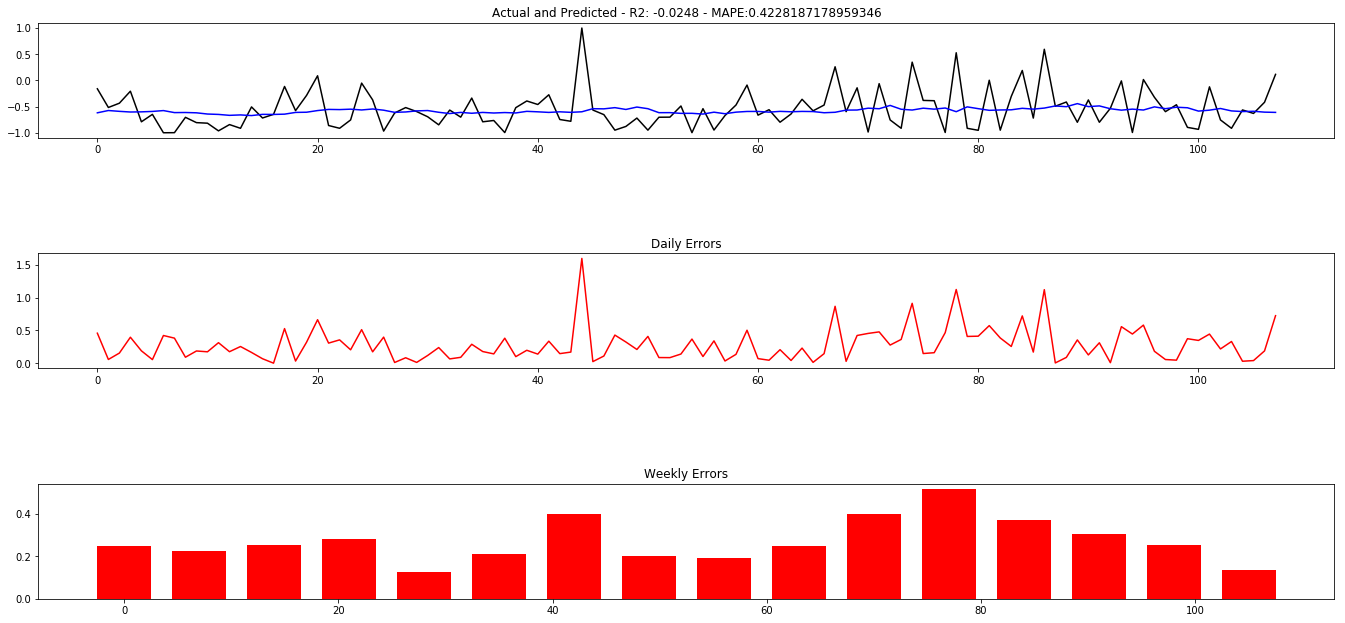

In [22]:
 plot_prediction(Y_val, model.predict(X_val))

# TEST

In [23]:
norm_test_daily_prices = minmax_norm(test_daily_prices, a=-1, b=1)
norm_test_daily_volumes = minmax_norm(test_daily_volumes, a=-1, b=1)

# Not Normalized

In [24]:
#normalized d_list
d_list = [test_daily_volumes, test_daily_prices]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


# Normalized

In [25]:
#normalized d_list
d_list = [norm_test_daily_volumes, norm_test_daily_prices]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

norm_test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    norm_test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61
index 61 is out of bounds for axis 0 with size 61


In [26]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

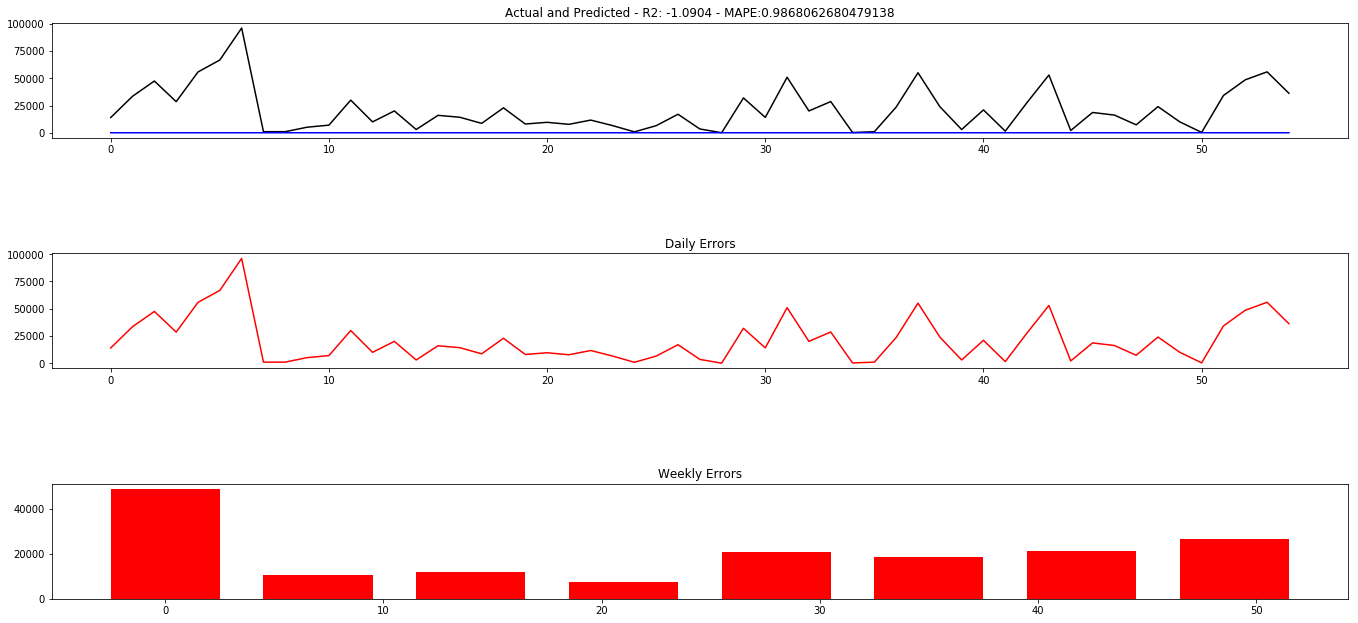

In [27]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_daily_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)

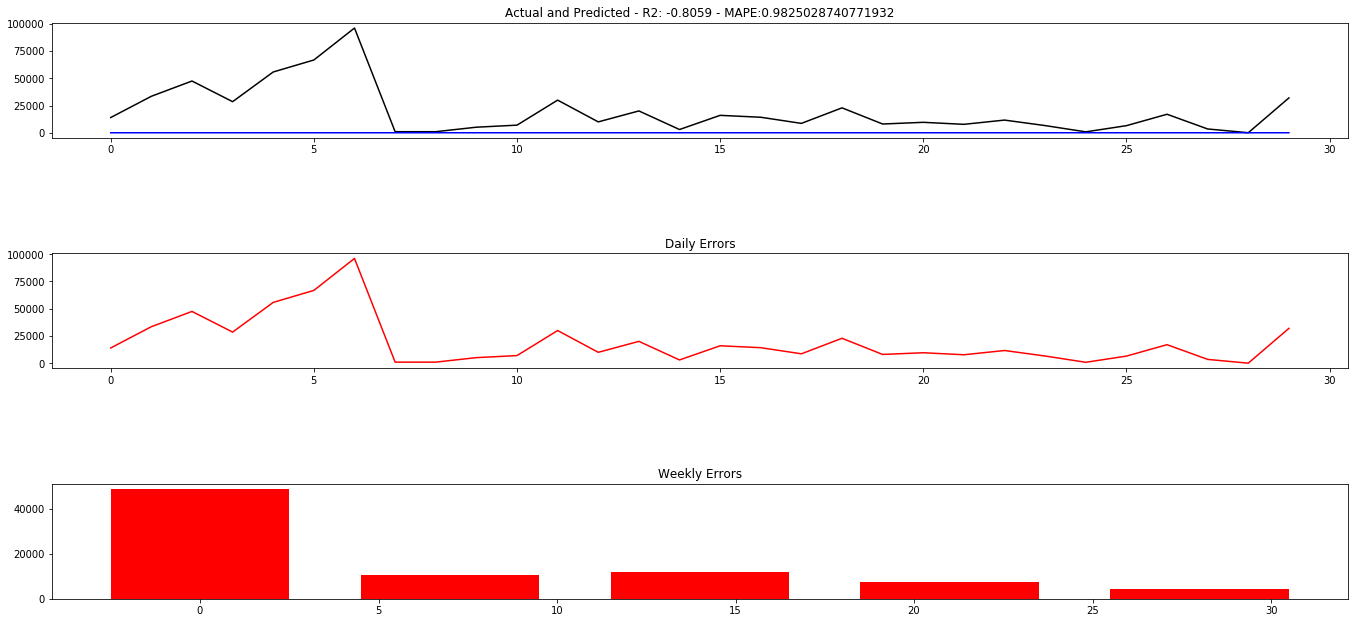

In [28]:
t=0
tp = 30
plot_prediction(not_norm_true_values[t:t+tp], pred_yy[t:t+tp])

# Training with Non-Normalized Data

In [29]:
nX_ = data_dict[w]['X']
nY_ = data_dict[w]['Y']
X_train_, X_val_, Y_train_, Y_val_ = get_train_validation(nX_, nY_)

In [30]:
print('X_train_: '+str(X_train_.shape))
print('X_val_: '+str(X_val_.shape))

X_train_: (429, 6, 2)
X_val_: (108, 6, 2)


In [31]:
print(X_train_[0])
print(Y_train_[0])
print('*'*50)
print(X_train_[1])
print(Y_train_[1])
print('*'*50)

[[4.63500000e+04 1.24056261e+01]
 [2.30000000e+03 1.18019263e+01]
 [1.55500000e+04 1.16870766e+01]
 [9.85000000e+03 1.90740122e+01]
 [1.78500000e+04 1.35251668e+01]
 [6.70000000e+03 1.16016418e+01]]
5100.0
**************************************************
[[2.30000000e+03 1.18019263e+01]
 [1.55500000e+04 1.16870766e+01]
 [9.85000000e+03 1.90740122e+01]
 [1.78500000e+04 1.35251668e+01]
 [6.70000000e+03 1.16016418e+01]
 [5.10000000e+03 1.34499410e+01]]
2000.0
**************************************************


In [32]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)

Model will be saved at: models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5


In [33]:
history = model.fit(X_train_, Y_train_, epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val_, Y_val_), validation_split=0.8, callbacks=callbacks)

Train on 429 samples, validate on 108 samples
Epoch 1/1000
416/429 [============================>.] - ETA: 0s - loss: 755578146.4615 - mean_absolute_error: 20554.7306 - mean_squared_error: 755578146.4615 - mean_absolute_percentage_error: 99.9741
Epoch 00001: val_loss improved from inf to 1132348797.62963, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 2s 5ms/step - loss: 747601017.6597 - mean_absolute_error: 20397.1395 - mean_squared_error: 747601017.6597 - mean_absolute_percentage_error: 99.9745 - val_loss: 1132348797.6296 - val_mean_absolute_error: 25984.4439 - val_mean_squared_error: 1132348797.6296 - val_mean_absolute_percentage_error: 99.9944
Epoch 2/1000
416/429 [============================>.] - ETA: 0s - loss: 757955241.8462 - mean_absolute_error: 20533.2045 - mean_squared_error: 757955241.8462 - mean_absolute_percentage_error: 99.9710
Epoch 00002: val_loss improved from 1132348797.62963 to 1132347247

Epoch 13/1000
416/429 [============================>.] - ETA: 0s - loss: 721127190.1538 - mean_absolute_error: 19993.0341 - mean_squared_error: 721127190.1538 - mean_absolute_percentage_error: 99.9020
Epoch 00013: val_loss improved from 1132321884.44444 to 1132320424.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 930us/step - loss: 747578633.8462 - mean_absolute_error: 20396.5892 - mean_squared_error: 747578633.8462 - mean_absolute_percentage_error: 99.9048 - val_loss: 1132320424.2963 - val_mean_absolute_error: 25983.8993 - val_mean_squared_error: 1132320424.2963 - val_mean_absolute_percentage_error: 99.9810
Epoch 14/1000
416/429 [============================>.] - ETA: 0s - loss: 724944172.3077 - mean_absolute_error: 20079.7120 - mean_squared_error: 724944172.3077 - mean_absolute_percentage_error: 99.8978
Epoch 00014: val_loss improved from 1132320424.29630 to 1132318945.18519, saving model to model

Epoch 25/1000
416/429 [============================>.] - ETA: 0s - loss: 735737580.3077 - mean_absolute_error: 20252.5992 - mean_squared_error: 735737580.3077 - mean_absolute_percentage_error: 99.8585
Epoch 00025: val_loss improved from 1132304604.44444 to 1132303253.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 791us/step - loss: 747565164.9044 - mean_absolute_error: 20396.2588 - mean_squared_error: 747565164.9044 - mean_absolute_percentage_error: 99.8622 - val_loss: 1132303253.3333 - val_mean_absolute_error: 25983.5686 - val_mean_squared_error: 1132303253.3333 - val_mean_absolute_percentage_error: 99.9728
Epoch 26/1000
416/429 [============================>.] - ETA: 0s - loss: 743824192.0000 - mean_absolute_error: 20366.5048 - mean_squared_error: 743824192.0000 - mean_absolute_percentage_error: 99.8552
Epoch 00026: val_loss improved from 1132303253.33333 to 1132301755.25926, saving model to model

Epoch 37/1000
416/429 [============================>.] - ETA: 0s - loss: 744370348.3077 - mean_absolute_error: 20395.3502 - mean_squared_error: 744370348.3077 - mean_absolute_percentage_error: 99.8188
Epoch 00037: val_loss improved from 1132287277.03704 to 1132285819.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 1ms/step - loss: 747551629.8741 - mean_absolute_error: 20395.9258 - mean_squared_error: 747551629.8741 - mean_absolute_percentage_error: 99.8210 - val_loss: 1132285819.2593 - val_mean_absolute_error: 25983.2327 - val_mean_squared_error: 1132285819.2593 - val_mean_absolute_percentage_error: 99.9644
Epoch 38/1000
384/429 [=========================>....] - ETA: 0s - loss: 746967162.6667 - mean_absolute_error: 20224.7765 - mean_squared_error: 746967162.6667 - mean_absolute_percentage_error: 99.7984
Epoch 00038: val_loss improved from 1132285819.25926 to 1132284437.33333, saving model to models/

Epoch 49/1000
416/429 [============================>.] - ETA: 0s - loss: 763556768.0000 - mean_absolute_error: 20633.0676 - mean_squared_error: 763556768.0000 - mean_absolute_percentage_error: 99.7742
Epoch 00049: val_loss improved from 1132269909.33333 to 1132268309.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 868us/step - loss: 747537969.9394 - mean_absolute_error: 20395.5908 - mean_squared_error: 747537969.9394 - mean_absolute_percentage_error: 99.7783 - val_loss: 1132268309.3333 - val_mean_absolute_error: 25982.8968 - val_mean_squared_error: 1132268309.3333 - val_mean_absolute_percentage_error: 99.9561
Epoch 50/1000
416/429 [============================>.] - ETA: 0s - loss: 752911812.9231 - mean_absolute_error: 20468.0237 - mean_squared_error: 752911812.9231 - mean_absolute_percentage_error: 99.7676
Epoch 00050: val_loss improved from 1132268309.33333 to 1132266996.14815, saving model to model

Epoch 61/1000
416/429 [============================>.] - ETA: 0s - loss: 735973393.2308 - mean_absolute_error: 20274.0923 - mean_squared_error: 735973393.2308 - mean_absolute_percentage_error: 99.7285
Epoch 00061: val_loss improved from 1132252520.29630 to 1132250882.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 835us/step - loss: 747524302.7692 - mean_absolute_error: 20395.2568 - mean_squared_error: 747524302.7692 - mean_absolute_percentage_error: 99.7351 - val_loss: 1132250882.3704 - val_mean_absolute_error: 25982.5608 - val_mean_squared_error: 1132250882.3704 - val_mean_absolute_percentage_error: 99.9477
Epoch 62/1000
416/429 [============================>.] - ETA: 0s - loss: 757521272.6154 - mean_absolute_error: 20476.7919 - mean_squared_error: 757521272.6154 - mean_absolute_percentage_error: 99.7238
Epoch 00062: val_loss improved from 1132250882.37037 to 1132249524.14815, saving model to model

Epoch 73/1000
416/429 [============================>.] - ETA: 0s - loss: 745611480.6154 - mean_absolute_error: 20326.5192 - mean_squared_error: 745611480.6154 - mean_absolute_percentage_error: 99.6844
Epoch 00073: val_loss improved from 1132234920.29630 to 1132233422.22222, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 825us/step - loss: 747510563.5058 - mean_absolute_error: 20394.9192 - mean_squared_error: 747510563.5058 - mean_absolute_percentage_error: 99.6924 - val_loss: 1132233422.2222 - val_mean_absolute_error: 25982.2249 - val_mean_squared_error: 1132233422.2222 - val_mean_absolute_percentage_error: 99.9393
Epoch 74/1000
416/429 [============================>.] - ETA: 0s - loss: 729256955.0769 - mean_absolute_error: 20111.0824 - mean_squared_error: 729256955.0769 - mean_absolute_percentage_error: 99.6806
Epoch 00074: val_loss improved from 1132233422.22222 to 1132231964.44444, saving model to model

Epoch 85/1000
416/429 [============================>.] - ETA: 0s - loss: 752882907.0769 - mean_absolute_error: 20486.2186 - mean_squared_error: 752882907.0769 - mean_absolute_percentage_error: 99.6432
Epoch 00085: val_loss improved from 1132217448.29630 to 1132215938.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 856us/step - loss: 747496803.9534 - mean_absolute_error: 20394.5825 - mean_squared_error: 747496803.9534 - mean_absolute_percentage_error: 99.6489 - val_loss: 1132215938.3704 - val_mean_absolute_error: 25981.8890 - val_mean_squared_error: 1132215938.3704 - val_mean_absolute_percentage_error: 99.9309
Epoch 86/1000
416/429 [============================>.] - ETA: 0s - loss: 756351982.7692 - mean_absolute_error: 20463.6979 - mean_squared_error: 756351982.7692 - mean_absolute_percentage_error: 99.6365
Epoch 00086: val_loss improved from 1132215938.37037 to 1132214402.37037, saving model to model

Epoch 97/1000
416/429 [============================>.] - ETA: 0s - loss: 750524093.5385 - mean_absolute_error: 20369.3218 - mean_squared_error: 750524093.5385 - mean_absolute_percentage_error: 99.5947
Epoch 00097: val_loss improved from 1132199867.25926 to 1132198364.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 859us/step - loss: 747483048.2797 - mean_absolute_error: 20394.2459 - mean_squared_error: 747483048.2797 - mean_absolute_percentage_error: 99.6063 - val_loss: 1132198364.4444 - val_mean_absolute_error: 25981.5491 - val_mean_squared_error: 1132198364.4444 - val_mean_absolute_percentage_error: 99.9225
Epoch 98/1000
416/429 [============================>.] - ETA: 0s - loss: 765834001.2308 - mean_absolute_error: 20707.9564 - mean_squared_error: 765834001.2308 - mean_absolute_percentage_error: 99.5930
Epoch 00098: val_loss improved from 1132198364.44444 to 1132196904.29630, saving model to model

Epoch 109/1000
416/429 [============================>.] - ETA: 0s - loss: 746045769.8462 - mean_absolute_error: 20292.9824 - mean_squared_error: 746045769.8462 - mean_absolute_percentage_error: 99.5521
Epoch 00109: val_loss improved from 1132182300.44444 to 1132180859.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 821us/step - loss: 747469307.9720 - mean_absolute_error: 20393.9084 - mean_squared_error: 747469307.9720 - mean_absolute_percentage_error: 99.5645 - val_loss: 1132180859.2593 - val_mean_absolute_error: 25981.2130 - val_mean_squared_error: 1132180859.2593 - val_mean_absolute_percentage_error: 99.9141
Epoch 110/1000
416/429 [============================>.] - ETA: 0s - loss: 748713459.6923 - mean_absolute_error: 20456.9398 - mean_squared_error: 748713459.6923 - mean_absolute_percentage_error: 99.5513
Epoch 00110: val_loss improved from 1132180859.25926 to 1132179406.22222, saving model to mod

Epoch 121/1000
416/429 [============================>.] - ETA: 0s - loss: 722747003.0769 - mean_absolute_error: 20151.7526 - mean_squared_error: 722747003.0769 - mean_absolute_percentage_error: 99.6892
Epoch 00121: val_loss improved from 1132164795.25926 to 1132163318.51852, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 834us/step - loss: 747455634.4988 - mean_absolute_error: 20393.5720 - mean_squared_error: 747455634.4988 - mean_absolute_percentage_error: 99.5215 - val_loss: 1132163318.5185 - val_mean_absolute_error: 25980.8761 - val_mean_squared_error: 1132163318.5185 - val_mean_absolute_percentage_error: 99.9058
Epoch 122/1000
416/429 [============================>.] - ETA: 0s - loss: 752365501.5385 - mean_absolute_error: 20374.6062 - mean_squared_error: 752365501.5385 - mean_absolute_percentage_error: 99.5057
Epoch 00122: val_loss improved from 1132163318.51852 to 1132161953.18519, saving model to mod

Epoch 133/1000
416/429 [============================>.] - ETA: 0s - loss: 754845238.1538 - mean_absolute_error: 20473.7770 - mean_squared_error: 754845238.1538 - mean_absolute_percentage_error: 99.4784
Epoch 00133: val_loss improved from 1132147221.33333 to 1132145711.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 849us/step - loss: 747441861.9674 - mean_absolute_error: 20393.2346 - mean_squared_error: 747441861.9674 - mean_absolute_percentage_error: 99.4914 - val_loss: 1132145711.4074 - val_mean_absolute_error: 25980.5374 - val_mean_squared_error: 1132145711.4074 - val_mean_absolute_percentage_error: 99.8973
Epoch 134/1000
416/429 [============================>.] - ETA: 0s - loss: 750506852.9231 - mean_absolute_error: 20435.0038 - mean_squared_error: 750506852.9231 - mean_absolute_percentage_error: 99.4758
Epoch 00134: val_loss improved from 1132145711.40741 to 1132144277.33333, saving model to mod

Epoch 145/1000
416/429 [============================>.] - ETA: 0s - loss: 743123428.9231 - mean_absolute_error: 20176.2106 - mean_squared_error: 743123428.9231 - mean_absolute_percentage_error: 99.4736
Epoch 00145: val_loss improved from 1132129704.29630 to 1132128258.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 839us/step - loss: 747427947.5618 - mean_absolute_error: 20392.8971 - mean_squared_error: 747427947.5618 - mean_absolute_percentage_error: 99.4887 - val_loss: 1132128258.3704 - val_mean_absolute_error: 25980.2015 - val_mean_squared_error: 1132128258.3704 - val_mean_absolute_percentage_error: 99.8889
Epoch 146/1000
416/429 [============================>.] - ETA: 0s - loss: 752289664.0000 - mean_absolute_error: 20491.8514 - mean_squared_error: 752289664.0000 - mean_absolute_percentage_error: 99.4737
Epoch 00146: val_loss improved from 1132128258.37037 to 1132126651.25926, saving model to mod

Epoch 157/1000
416/429 [============================>.] - ETA: 0s - loss: 752626023.3846 - mean_absolute_error: 20439.6085 - mean_squared_error: 752626023.3846 - mean_absolute_percentage_error: 99.4689
Epoch 00157: val_loss improved from 1132112033.18519 to 1132110556.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 872us/step - loss: 747413980.4942 - mean_absolute_error: 20392.5578 - mean_squared_error: 747413980.4942 - mean_absolute_percentage_error: 99.4834 - val_loss: 1132110556.4444 - val_mean_absolute_error: 25979.8605 - val_mean_squared_error: 1132110556.4444 - val_mean_absolute_percentage_error: 99.8805
Epoch 158/1000
416/429 [============================>.] - ETA: 0s - loss: 707041417.8462 - mean_absolute_error: 19974.7811 - mean_squared_error: 707041417.8462 - mean_absolute_percentage_error: 99.4683
Epoch 00158: val_loss improved from 1132110556.44444 to 1132109082.07407, saving model to mod

429/429 [==============================] - 0s 844us/step - loss: 747401142.1538 - mean_absolute_error: 20392.2466 - mean_squared_error: 747401142.1538 - mean_absolute_percentage_error: 99.4897 - val_loss: 1132094319.4074 - val_mean_absolute_error: 25979.5480 - val_mean_squared_error: 1132094319.4074 - val_mean_absolute_percentage_error: 99.8727
Epoch 169/1000
416/429 [============================>.] - ETA: 0s - loss: 750937811.6923 - mean_absolute_error: 20441.2615 - mean_squared_error: 750937811.6923 - mean_absolute_percentage_error: 99.4797
Epoch 00169: val_loss improved from 1132094319.40741 to 1132092935.11111, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 856us/step - loss: 747400017.1562 - mean_absolute_error: 20392.2181 - mean_squared_error: 747400017.1562 - mean_absolute_percentage_error: 99.4912 - val_loss: 1132092935.1111 - val_mean_absolute_error: 25979.5218 - val_mean_squared_error: 1132092935

Epoch 180/1000
416/429 [============================>.] - ETA: 0s - loss: 754130855.3846 - mean_absolute_error: 20471.2966 - mean_squared_error: 754130855.3846 - mean_absolute_percentage_error: 99.5072
Epoch 00180: val_loss improved from 1132078248.29630 to 1132076750.22222, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 747387281.8275 - mean_absolute_error: 20391.9103 - mean_squared_error: 747387281.8275 - mean_absolute_percentage_error: 99.5183 - val_loss: 1132076750.2222 - val_mean_absolute_error: 25979.2095 - val_mean_squared_error: 1132076750.2222 - val_mean_absolute_percentage_error: 99.8643
Epoch 181/1000
384/429 [=========================>....] - ETA: 0s - loss: 710271629.3333 - mean_absolute_error: 20171.8934 - mean_squared_error: 710271629.3333 - mean_absolute_percentage_error: 99.6445
Epoch 00181: val_loss improved from 1132076750.22222 to 1132075406.22222, saving model to model

Epoch 192/1000
416/429 [============================>.] - ETA: 0s - loss: 724884093.5385 - mean_absolute_error: 20167.9337 - mean_squared_error: 724884093.5385 - mean_absolute_percentage_error: 99.5332
Epoch 00192: val_loss improved from 1132060617.48148 to 1132059240.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 853us/step - loss: 747373410.4615 - mean_absolute_error: 20391.5739 - mean_squared_error: 747373410.4615 - mean_absolute_percentage_error: 99.5462 - val_loss: 1132059240.2963 - val_mean_absolute_error: 25978.8733 - val_mean_squared_error: 1132059240.2963 - val_mean_absolute_percentage_error: 99.8559
Epoch 193/1000
416/429 [============================>.] - ETA: 0s - loss: 761480674.4615 - mean_absolute_error: 20590.3719 - mean_squared_error: 761480674.4615 - mean_absolute_percentage_error: 99.5360
Epoch 00193: val_loss improved from 1132059240.29630 to 1132057647.40741, saving model to mod

Epoch 204/1000
416/429 [============================>.] - ETA: 0s - loss: 754380711.3846 - mean_absolute_error: 20518.5105 - mean_squared_error: 754380711.3846 - mean_absolute_percentage_error: 99.5641
Epoch 00204: val_loss improved from 1132043017.48148 to 1132041500.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 830us/step - loss: 747359568.8578 - mean_absolute_error: 20391.2371 - mean_squared_error: 747359568.8578 - mean_absolute_percentage_error: 99.5742 - val_loss: 1132041500.4444 - val_mean_absolute_error: 25978.5323 - val_mean_squared_error: 1132041500.4444 - val_mean_absolute_percentage_error: 99.8474
Epoch 205/1000
416/429 [============================>.] - ETA: 0s - loss: 760980317.5385 - mean_absolute_error: 20584.5168 - mean_squared_error: 760980317.5385 - mean_absolute_percentage_error: 99.5666
Epoch 00205: val_loss improved from 1132041500.44444 to 1132040156.44444, saving model to mod

Epoch 216/1000
416/429 [============================>.] - ETA: 0s - loss: 744576054.1538 - mean_absolute_error: 20313.5400 - mean_squared_error: 744576054.1538 - mean_absolute_percentage_error: 99.6022
Epoch 00216: val_loss improved from 1132025448.29630 to 1132023957.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 865us/step - loss: 747345766.9371 - mean_absolute_error: 20390.9025 - mean_squared_error: 747345766.9371 - mean_absolute_percentage_error: 99.6025 - val_loss: 1132023957.3333 - val_mean_absolute_error: 25978.1936 - val_mean_squared_error: 1132023957.3333 - val_mean_absolute_percentage_error: 99.8390
Epoch 217/1000
416/429 [============================>.] - ETA: 0s - loss: 744672167.3846 - mean_absolute_error: 20393.8692 - mean_squared_error: 744672167.3846 - mean_absolute_percentage_error: 99.5986
Epoch 00217: val_loss improved from 1132023957.33333 to 1132022459.25926, saving model to mod

Epoch 228/1000
416/429 [============================>.] - ETA: 0s - loss: 756563608.6154 - mean_absolute_error: 20490.2414 - mean_squared_error: 756563608.6154 - mean_absolute_percentage_error: 99.6256
Epoch 00228: val_loss improved from 1132007727.40741 to 1132006255.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 851us/step - loss: 747331887.1422 - mean_absolute_error: 20390.5648 - mean_squared_error: 747331887.1422 - mean_absolute_percentage_error: 99.6310 - val_loss: 1132006255.4074 - val_mean_absolute_error: 25977.8524 - val_mean_squared_error: 1132006255.4074 - val_mean_absolute_percentage_error: 99.8305
Epoch 229/1000
416/429 [============================>.] - ETA: 0s - loss: 730158968.6154 - mean_absolute_error: 20278.5796 - mean_squared_error: 730158968.6154 - mean_absolute_percentage_error: 99.6270
Epoch 00229: val_loss improved from 1132006255.40741 to 1132004847.40741, saving model to mod

Epoch 240/1000
384/429 [=========================>....] - ETA: 0s - loss: 706701498.6667 - mean_absolute_error: 20013.5160 - mean_squared_error: 706701498.6667 - mean_absolute_percentage_error: 99.6357
Epoch 00240: val_loss improved from 1131990279.11111 to 1131988764.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 747318144.2984 - mean_absolute_error: 20390.2316 - mean_squared_error: 747318144.2984 - mean_absolute_percentage_error: 99.6575 - val_loss: 1131988764.4444 - val_mean_absolute_error: 25977.5167 - val_mean_squared_error: 1131988764.4444 - val_mean_absolute_percentage_error: 99.8221
Epoch 241/1000
416/429 [============================>.] - ETA: 0s - loss: 720921814.1538 - mean_absolute_error: 20025.3376 - mean_squared_error: 720921814.1538 - mean_absolute_percentage_error: 99.6527
Epoch 00241: val_loss improved from 1131988764.44444 to 1131987304.29630, saving model to model

Epoch 252/1000
416/429 [============================>.] - ETA: 0s - loss: 743623648.0000 - mean_absolute_error: 20400.1681 - mean_squared_error: 743623648.0000 - mean_absolute_percentage_error: 99.6825
Epoch 00252: val_loss improved from 1131972572.44444 to 1131971119.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 850us/step - loss: 747304318.0606 - mean_absolute_error: 20389.8950 - mean_squared_error: 747304318.0606 - mean_absolute_percentage_error: 99.6862 - val_loss: 1131971119.4074 - val_mean_absolute_error: 25977.1780 - val_mean_squared_error: 1131971119.4074 - val_mean_absolute_percentage_error: 99.8137
Epoch 253/1000
416/429 [============================>.] - ETA: 0s - loss: 761827726.7692 - mean_absolute_error: 20653.3451 - mean_squared_error: 761827726.7692 - mean_absolute_percentage_error: 99.6910
Epoch 00253: val_loss improved from 1131971119.40741 to 1131969564.44444, saving model to mod

Epoch 264/1000
416/429 [============================>.] - ETA: 0s - loss: 753970636.3077 - mean_absolute_error: 20482.2328 - mean_squared_error: 753970636.3077 - mean_absolute_percentage_error: 99.7231
Epoch 00264: val_loss improved from 1131954972.44444 to 1131953512.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 859us/step - loss: 747290513.7529 - mean_absolute_error: 20389.5590 - mean_squared_error: 747290513.7529 - mean_absolute_percentage_error: 99.7147 - val_loss: 1131953512.2963 - val_mean_absolute_error: 25976.8368 - val_mean_squared_error: 1131953512.2963 - val_mean_absolute_percentage_error: 99.8052
Epoch 265/1000
416/429 [============================>.] - ETA: 0s - loss: 754563623.3846 - mean_absolute_error: 20524.1252 - mean_squared_error: 754563623.3846 - mean_absolute_percentage_error: 99.7252
Epoch 00265: val_loss improved from 1131953512.29630 to 1131952040.29630, saving model to mod

Epoch 276/1000
416/429 [============================>.] - ETA: 0s - loss: 750266468.9231 - mean_absolute_error: 20351.9788 - mean_squared_error: 750266468.9231 - mean_absolute_percentage_error: 99.7379
Epoch 00276: val_loss improved from 1131937365.33333 to 1131935855.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 847us/step - loss: 747276738.8345 - mean_absolute_error: 20389.2240 - mean_squared_error: 747276738.8345 - mean_absolute_percentage_error: 99.7433 - val_loss: 1131935855.4074 - val_mean_absolute_error: 25976.4983 - val_mean_squared_error: 1131935855.4074 - val_mean_absolute_percentage_error: 99.7968
Epoch 277/1000
416/429 [============================>.] - ETA: 0s - loss: 762459298.4615 - mean_absolute_error: 20604.6382 - mean_squared_error: 762459298.4615 - mean_absolute_percentage_error: 99.7402
Epoch 00277: val_loss improved from 1131935855.40741 to 1131934435.55556, saving model to mod

Epoch 288/1000
416/429 [============================>.] - ETA: 0s - loss: 741113462.1538 - mean_absolute_error: 20192.0995 - mean_squared_error: 741113462.1538 - mean_absolute_percentage_error: 99.7656
Epoch 00288: val_loss improved from 1131919727.40741 to 1131918267.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 854us/step - loss: 747262943.1795 - mean_absolute_error: 20388.8890 - mean_squared_error: 747262943.1795 - mean_absolute_percentage_error: 99.7707 - val_loss: 1131918267.2593 - val_mean_absolute_error: 25976.1585 - val_mean_squared_error: 1131918267.2593 - val_mean_absolute_percentage_error: 99.7884
Epoch 289/1000
416/429 [============================>.] - ETA: 0s - loss: 749573548.3077 - mean_absolute_error: 20411.9045 - mean_squared_error: 749573548.3077 - mean_absolute_percentage_error: 99.7685
Epoch 00289: val_loss improved from 1131918267.25926 to 1131916859.25926, saving model to mod

Epoch 300/1000
416/429 [============================>.] - ETA: 0s - loss: 746273597.5385 - mean_absolute_error: 20324.5904 - mean_squared_error: 746273597.5385 - mean_absolute_percentage_error: 99.7950
Epoch 00300: val_loss improved from 1131902229.33333 to 1131900757.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 839us/step - loss: 747249165.1282 - mean_absolute_error: 20388.5541 - mean_squared_error: 747249165.1282 - mean_absolute_percentage_error: 99.7984 - val_loss: 1131900757.3333 - val_mean_absolute_error: 25975.8212 - val_mean_squared_error: 1131900757.3333 - val_mean_absolute_percentage_error: 99.7799
Epoch 301/1000
416/429 [============================>.] - ETA: 0s - loss: 752827352.6154 - mean_absolute_error: 20460.5816 - mean_squared_error: 752827352.6154 - mean_absolute_percentage_error: 99.7978
Epoch 00301: val_loss improved from 1131900757.33333 to 1131899221.33333, saving model to mod

Epoch 312/1000
384/429 [=========================>....] - ETA: 0s - loss: 753140818.6667 - mean_absolute_error: 20497.1449 - mean_squared_error: 753140818.6667 - mean_absolute_percentage_error: 99.7605
Epoch 00312: val_loss improved from 1131884565.33333 to 1131883157.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 747235397.5198 - mean_absolute_error: 20388.2188 - mean_squared_error: 747235397.5198 - mean_absolute_percentage_error: 99.8268 - val_loss: 1131883157.3333 - val_mean_absolute_error: 25975.4827 - val_mean_squared_error: 1131883157.3333 - val_mean_absolute_percentage_error: 99.7715
Epoch 313/1000
416/429 [============================>.] - ETA: 0s - loss: 745567030.1538 - mean_absolute_error: 20349.1965 - mean_squared_error: 745567030.1538 - mean_absolute_percentage_error: 99.8360
Epoch 00313: val_loss improved from 1131883157.33333 to 1131881735.11111, saving model to model

Epoch 324/1000
416/429 [============================>.] - ETA: 0s - loss: 762685334.1538 - mean_absolute_error: 20631.2523 - mean_squared_error: 762685334.1538 - mean_absolute_percentage_error: 99.8596
Epoch 00324: val_loss improved from 1131867043.55556 to 1131865621.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 818us/step - loss: 747221593.3613 - mean_absolute_error: 20387.8841 - mean_squared_error: 747221593.3613 - mean_absolute_percentage_error: 99.8550 - val_loss: 1131865621.3333 - val_mean_absolute_error: 25975.1468 - val_mean_squared_error: 1131865621.3333 - val_mean_absolute_percentage_error: 99.7631
Epoch 325/1000
416/429 [============================>.] - ETA: 0s - loss: 734070845.5385 - mean_absolute_error: 20152.8122 - mean_squared_error: 734070845.5385 - mean_absolute_percentage_error: 99.8545
Epoch 00325: val_loss improved from 1131865621.33333 to 1131864137.48148, saving model to mod

Epoch 336/1000
416/429 [============================>.] - ETA: 0s - loss: 752064327.3846 - mean_absolute_error: 20472.5412 - mean_squared_error: 752064327.3846 - mean_absolute_percentage_error: 99.8888
Epoch 00336: val_loss improved from 1131849443.55556 to 1131848059.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 832us/step - loss: 747207817.1002 - mean_absolute_error: 20387.5492 - mean_squared_error: 747207817.1002 - mean_absolute_percentage_error: 99.8819 - val_loss: 1131848059.2593 - val_mean_absolute_error: 25974.8067 - val_mean_squared_error: 1131848059.2593 - val_mean_absolute_percentage_error: 99.7547
Epoch 337/1000
416/429 [============================>.] - ETA: 0s - loss: 735237043.6923 - mean_absolute_error: 20165.5479 - mean_squared_error: 735237043.6923 - mean_absolute_percentage_error: 99.8872
Epoch 00337: val_loss improved from 1131848059.25926 to 1131846549.33333, saving model to mod

429/429 [==============================] - 0s 843us/step - loss: 747195120.7832 - mean_absolute_error: 20387.2416 - mean_squared_error: 747195120.7832 - mean_absolute_percentage_error: 99.9072 - val_loss: 1131831938.3704 - val_mean_absolute_error: 25974.4983 - val_mean_squared_error: 1131831938.3704 - val_mean_absolute_percentage_error: 99.7469
Epoch 348/1000
416/429 [============================>.] - ETA: 0s - loss: 750373735.3846 - mean_absolute_error: 20433.4652 - mean_squared_error: 750373735.3846 - mean_absolute_percentage_error: 99.9182
Epoch 00348: val_loss improved from 1131831938.37037 to 1131830364.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 812us/step - loss: 747193952.3730 - mean_absolute_error: 20387.2129 - mean_squared_error: 747193952.3730 - mean_absolute_percentage_error: 99.9102 - val_loss: 1131830364.4444 - val_mean_absolute_error: 25974.4671 - val_mean_squared_error: 1131830364

416/429 [============================>.] - ETA: 0s - loss: 734651928.6154 - mean_absolute_error: 20246.3791 - mean_squared_error: 734651928.6154 - mean_absolute_percentage_error: 99.9441
Epoch 00359: val_loss improved from 1131815727.40741 to 1131814274.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 840us/step - loss: 747181300.9604 - mean_absolute_error: 20386.9064 - mean_squared_error: 747181300.9604 - mean_absolute_percentage_error: 99.9373 - val_loss: 1131814274.3704 - val_mean_absolute_error: 25974.1573 - val_mean_squared_error: 1131814274.3704 - val_mean_absolute_percentage_error: 99.7385
Epoch 360/1000
416/429 [============================>.] - ETA: 0s - loss: 762371470.7692 - mean_absolute_error: 20603.7431 - mean_squared_error: 762371470.7692 - mean_absolute_percentage_error: 99.9557   - ETA: 0s - loss: 805865979.4286 - mean_absolute_error: 21198.0469 - mean_squared_error: 805865979.4286 - 

Epoch 371/1000
384/429 [=========================>....] - ETA: 0s - loss: 778798685.3333 - mean_absolute_error: 20717.2935 - mean_squared_error: 778798685.3333 - mean_absolute_percentage_error: 99.9851
Epoch 00371: val_loss improved from 1131798158.22222 to 1131796629.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 1ms/step - loss: 747167512.6900 - mean_absolute_error: 20386.5698 - mean_squared_error: 747167512.6900 - mean_absolute_percentage_error: 99.9647 - val_loss: 1131796629.3333 - val_mean_absolute_error: 25973.8186 - val_mean_squared_error: 1131796629.3333 - val_mean_absolute_percentage_error: 99.7301
Epoch 372/1000
416/429 [============================>.] - ETA: 0s - loss: 755871118.7692 - mean_absolute_error: 20529.1662 - mean_squared_error: 755871118.7692 - mean_absolute_percentage_error: 99.9712 
Epoch 00372: val_loss improved from 1131796629.33333 to 1131795228.44444, saving model to mode

Epoch 383/1000
416/429 [============================>.] - ETA: 0s - loss: 750092504.6154 - mean_absolute_error: 20439.8094 - mean_squared_error: 750092504.6154 - mean_absolute_percentage_error: 99.9980
Epoch 00383: val_loss improved from 1131780598.51852 to 1131779176.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 819us/step - loss: 747153749.9301 - mean_absolute_error: 20386.2351 - mean_squared_error: 747153749.9301 - mean_absolute_percentage_error: 99.9936 - val_loss: 1131779176.2963 - val_mean_absolute_error: 25973.4827 - val_mean_squared_error: 1131779176.2963 - val_mean_absolute_percentage_error: 99.7217
Epoch 384/1000
384/429 [=========================>....] - ETA: 0s - loss: 785731221.3333 - mean_absolute_error: 20890.3581 - mean_squared_error: 785731221.3333 - mean_absolute_percentage_error: 100.0300
Epoch 00384: val_loss improved from 1131779176.29630 to 1131777590.51852, saving model to mo

Epoch 395/1000
416/429 [============================>.] - ETA: 0s - loss: 740561848.6154 - mean_absolute_error: 20291.0642 - mean_squared_error: 740561848.6154 - mean_absolute_percentage_error: 100.0264
Epoch 00395: val_loss improved from 1131762965.33333 to 1131761474.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 747139889.0816 - mean_absolute_error: 20385.8984 - mean_squared_error: 747139889.0816 - mean_absolute_percentage_error: 100.0203 - val_loss: 1131761474.3704 - val_mean_absolute_error: 25973.1417 - val_mean_squared_error: 1131761474.3704 - val_mean_absolute_percentage_error: 99.7132
Epoch 396/1000
416/429 [============================>.] - ETA: 0s - loss: 745616669.5385 - mean_absolute_error: 20306.0901 - mean_squared_error: 745616669.5385 - mean_absolute_percentage_error: 100.0287
Epoch 00396: val_loss improved from 1131761474.37037 to 1131760002.37037, saving model to mo

Epoch 407/1000
416/429 [============================>.] - ETA: 0s - loss: 715172819.6923 - mean_absolute_error: 20113.0648 - mean_squared_error: 715172819.6923 - mean_absolute_percentage_error: 100.0562
Epoch 00407: val_loss improved from 1131745320.29630 to 1131743912.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 851us/step - loss: 747126050.6107 - mean_absolute_error: 20385.5623 - mean_squared_error: 747126050.6107 - mean_absolute_percentage_error: 100.0495 - val_loss: 1131743912.2963 - val_mean_absolute_error: 25972.8030 - val_mean_squared_error: 1131743912.2963 - val_mean_absolute_percentage_error: 99.7048
Epoch 408/1000
416/429 [============================>.] - ETA: 0s - loss: 752648669.5385 - mean_absolute_error: 20495.9592 - mean_squared_error: 752648669.5385 - mean_absolute_percentage_error: 99.8237
Epoch 00408: val_loss improved from 1131743912.29630 to 1131742300.44444, saving model to m

Epoch 419/1000
416/429 [============================>.] - ETA: 0s - loss: 751030385.2308 - mean_absolute_error: 20388.4627 - mean_squared_error: 751030385.2308 - mean_absolute_percentage_error: 100.0833
Epoch 00419: val_loss improved from 1131727817.48148 to 1131726319.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 842us/step - loss: 747112290.1632 - mean_absolute_error: 20385.2283 - mean_squared_error: 747112290.1632 - mean_absolute_percentage_error: 100.0765 - val_loss: 1131726319.4074 - val_mean_absolute_error: 25972.4632 - val_mean_squared_error: 1131726319.4074 - val_mean_absolute_percentage_error: 99.6964
Epoch 420/1000
416/429 [============================>.] - ETA: 0s - loss: 759112364.3077 - mean_absolute_error: 20537.3914 - mean_squared_error: 759112364.3077 - mean_absolute_percentage_error: 100.0883
Epoch 00420: val_loss improved from 1131726319.40741 to 1131724840.29630, saving model to 

Epoch 431/1000
416/429 [============================>.] - ETA: 0s - loss: 759104384.0000 - mean_absolute_error: 20557.0183 - mean_squared_error: 759104384.0000 - mean_absolute_percentage_error: 100.1192
Epoch 00431: val_loss improved from 1131710248.29630 to 1131708738.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 747098544.4848 - mean_absolute_error: 20384.8932 - mean_squared_error: 747098544.4848 - mean_absolute_percentage_error: 100.1056 - val_loss: 1131708738.3704 - val_mean_absolute_error: 25972.1261 - val_mean_squared_error: 1131708738.3704 - val_mean_absolute_percentage_error: 99.6879
Epoch 432/1000
416/429 [============================>.] - ETA: 0s - loss: 763798390.1538 - mean_absolute_error: 20692.3080 - mean_squared_error: 763798390.1538 - mean_absolute_percentage_error: 100.1220
Epoch 00432: val_loss improved from 1131708738.37037 to 1131707394.37037, saving model to mo

Epoch 443/1000
416/429 [============================>.] - ETA: 0s - loss: 757759345.2308 - mean_absolute_error: 20595.8366 - mean_squared_error: 757759345.2308 - mean_absolute_percentage_error: 100.1724
Epoch 00443: val_loss improved from 1131692622.22222 to 1131691176.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 869us/step - loss: 747084747.8601 - mean_absolute_error: 20384.5587 - mean_squared_error: 747084747.8601 - mean_absolute_percentage_error: 100.1331 - val_loss: 1131691176.2963 - val_mean_absolute_error: 25971.7874 - val_mean_squared_error: 1131691176.2963 - val_mean_absolute_percentage_error: 99.6795
Epoch 444/1000
416/429 [============================>.] - ETA: 0s - loss: 736471744.0000 - mean_absolute_error: 20274.9294 - mean_squared_error: 736471744.0000 - mean_absolute_percentage_error: 100.0062
Epoch 00444: val_loss improved from 1131691176.29630 to 1131689699.55556, saving model to 

429/429 [==============================] - 0s 846us/step - loss: 747072145.3054 - mean_absolute_error: 20384.2516 - mean_squared_error: 747072145.3054 - mean_absolute_percentage_error: 100.1586 - val_loss: 1131675100.4444 - val_mean_absolute_error: 25971.4774 - val_mean_squared_error: 1131675100.4444 - val_mean_absolute_percentage_error: 99.6718
Epoch 455/1000
416/429 [============================>.] - ETA: 0s - loss: 751595921.2308 - mean_absolute_error: 20403.2918 - mean_squared_error: 751595921.2308 - mean_absolute_percentage_error: 100.1812
Epoch 00455: val_loss improved from 1131675100.44444 to 1131673647.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 831us/step - loss: 747070994.6480 - mean_absolute_error: 20384.2241 - mean_squared_error: 747070994.6480 - mean_absolute_percentage_error: 100.1611 - val_loss: 1131673647.4074 - val_mean_absolute_error: 25971.4515 - val_mean_squared_error: 1131673

416/429 [============================>.] - ETA: 0s - loss: 744532420.9231 - mean_absolute_error: 20313.1638 - mean_squared_error: 744532420.9231 - mean_absolute_percentage_error: 100.1979
Epoch 00466: val_loss improved from 1131658939.25926 to 1131657481.48148, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 877us/step - loss: 747058335.9254 - mean_absolute_error: 20383.9170 - mean_squared_error: 747058335.9254 - mean_absolute_percentage_error: 100.1862 - val_loss: 1131657481.4815 - val_mean_absolute_error: 25971.1390 - val_mean_squared_error: 1131657481.4815 - val_mean_absolute_percentage_error: 99.6634
Epoch 467/1000
416/429 [============================>.] - ETA: 0s - loss: 749196219.0769 - mean_absolute_error: 20356.3697 - mean_squared_error: 749196219.0769 - mean_absolute_percentage_error: 100.2039
Epoch 00467: val_loss improved from 1131657481.48148 to 1131656116.14815, saving model to models/bidirlst

429/429 [==============================] - 0s 843us/step - loss: 747045715.6177 - mean_absolute_error: 20383.6081 - mean_squared_error: 747045715.6177 - mean_absolute_percentage_error: 100.2116 - val_loss: 1131641256.2963 - val_mean_absolute_error: 25970.8265 - val_mean_squared_error: 1131641256.2963 - val_mean_absolute_percentage_error: 99.6556
Epoch 478/1000
416/429 [============================>.] - ETA: 0s - loss: 740358390.1538 - mean_absolute_error: 20286.1250 - mean_squared_error: 740358390.1538 - mean_absolute_percentage_error: 100.2274
Epoch 00478: val_loss improved from 1131641256.29630 to 1131639924.14815, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 846us/step - loss: 747044530.5734 - mean_absolute_error: 20383.5804 - mean_squared_error: 747044530.5734 - mean_absolute_percentage_error: 100.2137 - val_loss: 1131639924.1481 - val_mean_absolute_error: 25970.7991 - val_mean_squared_error: 1131639

416/429 [============================>.] - ETA: 0s - loss: 744745651.6923 - mean_absolute_error: 20379.5165 - mean_squared_error: 744745651.6923 - mean_absolute_percentage_error: 100.2521
Epoch 00489: val_loss improved from 1131625256.29630 to 1131623765.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 838us/step - loss: 747031924.0653 - mean_absolute_error: 20383.2743 - mean_squared_error: 747031924.0653 - mean_absolute_percentage_error: 100.2393 - val_loss: 1131623765.3333 - val_mean_absolute_error: 25970.4905 - val_mean_squared_error: 1131623765.3333 - val_mean_absolute_percentage_error: 99.6472
Epoch 490/1000
416/429 [============================>.] - ETA: 0s - loss: 753400792.6154 - mean_absolute_error: 20445.1863 - mean_squared_error: 753400792.6154 - mean_absolute_percentage_error: 100.2582
Epoch 00490: val_loss improved from 1131623765.33333 to 1131622326.51852, saving model to models/bidirlst

Epoch 501/1000
384/429 [=========================>....] - ETA: 0s - loss: 762758176.0000 - mean_absolute_error: 20452.6159 - mean_squared_error: 762758176.0000 - mean_absolute_percentage_error: 100.3191
Epoch 00501: val_loss improved from 1131607682.37037 to 1131606203.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 747018153.8462 - mean_absolute_error: 20382.9391 - mean_squared_error: 747018153.8462 - mean_absolute_percentage_error: 100.2685 - val_loss: 1131606203.2593 - val_mean_absolute_error: 25970.1507 - val_mean_squared_error: 1131606203.2593 - val_mean_absolute_percentage_error: 99.6388
Epoch 502/1000
416/429 [============================>.] - ETA: 0s - loss: 758923773.5385 - mean_absolute_error: 20612.1584 - mean_squared_error: 758923773.5385 - mean_absolute_percentage_error: 100.2942
Epoch 00502: val_loss improved from 1131606203.25926 to 1131604743.11111, saving model to mo

Epoch 513/1000
416/429 [============================>.] - ETA: 0s - loss: 754185139.6923 - mean_absolute_error: 20414.3508 - mean_squared_error: 754185139.6923 - mean_absolute_percentage_error: 100.3096
Epoch 00513: val_loss improved from 1131590089.48148 to 1131588539.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 847us/step - loss: 747004351.7016 - mean_absolute_error: 20382.6036 - mean_squared_error: 747004351.7016 - mean_absolute_percentage_error: 100.2972 - val_loss: 1131588539.2593 - val_mean_absolute_error: 25969.8108 - val_mean_squared_error: 1131588539.2593 - val_mean_absolute_percentage_error: 99.6303
Epoch 514/1000
416/429 [============================>.] - ETA: 0s - loss: 751145097.8462 - mean_absolute_error: 20413.4689 - mean_squared_error: 751145097.8462 - mean_absolute_percentage_error: 100.3159
Epoch 00514: val_loss improved from 1131588539.25926 to 1131587138.37037, saving model to 

Epoch 525/1000
416/429 [============================>.] - ETA: 0s - loss: 759969102.7692 - mean_absolute_error: 20561.8012 - mean_squared_error: 759969102.7692 - mean_absolute_percentage_error: 100.3489
Epoch 00525: val_loss improved from 1131572425.48148 to 1131570972.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 823us/step - loss: 746990501.5944 - mean_absolute_error: 20382.2678 - mean_squared_error: 746990501.5944 - mean_absolute_percentage_error: 100.3238 - val_loss: 1131570972.4444 - val_mean_absolute_error: 25969.4749 - val_mean_squared_error: 1131570972.4444 - val_mean_absolute_percentage_error: 99.6219
Epoch 526/1000
416/429 [============================>.] - ETA: 0s - loss: 757450299.0769 - mean_absolute_error: 20481.1953 - mean_squared_error: 757450299.0769 - mean_absolute_percentage_error: 100.3426
Epoch 00526: val_loss improved from 1131570972.44444 to 1131569455.40741, saving model to 

Epoch 537/1000
416/429 [============================>.] - ETA: 0s - loss: 751706121.8462 - mean_absolute_error: 20437.1485 - mean_squared_error: 751706121.8462 - mean_absolute_percentage_error: 100.3709
Epoch 00537: val_loss improved from 1131554818.37037 to 1131553346.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 856us/step - loss: 746976721.3054 - mean_absolute_error: 20381.9313 - mean_squared_error: 746976721.3054 - mean_absolute_percentage_error: 100.3526 - val_loss: 1131553346.3704 - val_mean_absolute_error: 25969.1337 - val_mean_squared_error: 1131553346.3704 - val_mean_absolute_percentage_error: 99.6135
Epoch 538/1000
416/429 [============================>.] - ETA: 0s - loss: 712399773.5385 - mean_absolute_error: 20059.0839 - mean_squared_error: 712399773.5385 - mean_absolute_percentage_error: 100.3756
Epoch 00538: val_loss improved from 1131553346.37037 to 1131551893.33333, saving model to 

Epoch 549/1000
416/429 [============================>.] - ETA: 0s - loss: 756832204.3077 - mean_absolute_error: 20534.6957 - mean_squared_error: 756832204.3077 - mean_absolute_percentage_error: 100.4070
Epoch 00549: val_loss improved from 1131537256.29630 to 1131535727.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 844us/step - loss: 746962939.4499 - mean_absolute_error: 20381.5972 - mean_squared_error: 746962939.4499 - mean_absolute_percentage_error: 100.3812 - val_loss: 1131535727.4074 - val_mean_absolute_error: 25968.7952 - val_mean_squared_error: 1131535727.4074 - val_mean_absolute_percentage_error: 99.6050
Epoch 550/1000
416/429 [============================>.] - ETA: 0s - loss: 759245390.7692 - mean_absolute_error: 20508.4366 - mean_squared_error: 759245390.7692 - mean_absolute_percentage_error: 100.4059
Epoch 00550: val_loss improved from 1131535727.40741 to 1131534262.51852, saving model to 

Epoch 561/1000
416/429 [============================>.] - ETA: 0s - loss: 722500445.5385 - mean_absolute_error: 20039.4890 - mean_squared_error: 722500445.5385 - mean_absolute_percentage_error: 100.4435
Epoch 00561: val_loss improved from 1131519670.51852 to 1131518312.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 835us/step - loss: 746949160.2797 - mean_absolute_error: 20381.2630 - mean_squared_error: 746949160.2797 - mean_absolute_percentage_error: 100.4084 - val_loss: 1131518312.2963 - val_mean_absolute_error: 25968.4593 - val_mean_squared_error: 1131518312.2963 - val_mean_absolute_percentage_error: 99.5966
Epoch 562/1000
416/429 [============================>.] - ETA: 0s - loss: 756279958.1538 - mean_absolute_error: 20529.8202 - mean_squared_error: 756279958.1538 - mean_absolute_percentage_error: 99.9420 
Epoch 00562: val_loss improved from 1131518312.29630 to 1131516738.37037, saving model to 

Epoch 573/1000
384/429 [=========================>....] - ETA: 0s - loss: 736535344.0000 - mean_absolute_error: 20408.6382 - mean_squared_error: 736535344.0000 - mean_absolute_percentage_error: 100.1793
Epoch 00573: val_loss improved from 1131502044.44444 to 1131500617.48148, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 883us/step - loss: 746935352.3916 - mean_absolute_error: 20380.9260 - mean_squared_error: 746935352.3916 - mean_absolute_percentage_error: 100.4371 - val_loss: 1131500617.4815 - val_mean_absolute_error: 25968.1181 - val_mean_squared_error: 1131500617.4815 - val_mean_absolute_percentage_error: 99.5882
Epoch 574/1000
416/429 [============================>.] - ETA: 0s - loss: 726773742.7692 - mean_absolute_error: 20118.6200 - mean_squared_error: 726773742.7692 - mean_absolute_percentage_error: 100.4572
Epoch 00574: val_loss improved from 1131500617.48148 to 1131499195.25926, saving model to 

Epoch 585/1000
416/429 [============================>.] - ETA: 0s - loss: 765300615.3846 - mean_absolute_error: 20751.0171 - mean_squared_error: 765300615.3846 - mean_absolute_percentage_error: 100.5113
Epoch 00585: val_loss improved from 1131484418.37037 to 1131482965.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 840us/step - loss: 746921584.8578 - mean_absolute_error: 20380.5913 - mean_squared_error: 746921584.8578 - mean_absolute_percentage_error: 100.4643 - val_loss: 1131482965.3333 - val_mean_absolute_error: 25967.7796 - val_mean_squared_error: 1131482965.3333 - val_mean_absolute_percentage_error: 99.5797
Epoch 586/1000
416/429 [============================>.] - ETA: 0s - loss: 747688637.5385 - mean_absolute_error: 20388.6209 - mean_squared_error: 747688637.5385 - mean_absolute_percentage_error: 100.4875
Epoch 00586: val_loss improved from 1131482965.33333 to 1131481507.55556, saving model to 

429/429 [==============================] - 0s 844us/step - loss: 746908904.1305 - mean_absolute_error: 20380.2828 - mean_squared_error: 746908904.1305 - mean_absolute_percentage_error: 100.4906 - val_loss: 1131466792.2963 - val_mean_absolute_error: 25967.4671 - val_mean_squared_error: 1131466792.2963 - val_mean_absolute_percentage_error: 99.5720
Epoch 597/1000
416/429 [============================>.] - ETA: 0s - loss: 756864699.0769 - mean_absolute_error: 20477.5908 - mean_squared_error: 756864699.0769 - mean_absolute_percentage_error: 100.5297
Epoch 00597: val_loss improved from 1131466792.29630 to 1131465384.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 861us/step - loss: 746907699.4685 - mean_absolute_error: 20380.2547 - mean_squared_error: 746907699.4685 - mean_absolute_percentage_error: 100.4941 - val_loss: 1131465384.2963 - val_mean_absolute_error: 25967.4397 - val_mean_squared_error: 1131465

416/429 [============================>.] - ETA: 0s - loss: 745429681.2308 - mean_absolute_error: 20336.4672 - mean_squared_error: 745429681.2308 - mean_absolute_percentage_error: 100.6631
Epoch 00608: val_loss improved from 1131377493.33333 to 1131374651.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 900us/step - loss: 746837497.4359 - mean_absolute_error: 20378.5449 - mean_squared_error: 746837497.4359 - mean_absolute_percentage_error: 100.6371 - val_loss: 1131374651.2593 - val_mean_absolute_error: 25965.6936 - val_mean_squared_error: 1131374651.2593 - val_mean_absolute_percentage_error: 99.5278
Epoch 609/1000
416/429 [============================>.] - ETA: 0s - loss: 753485307.0769 - mean_absolute_error: 20484.7003 - mean_squared_error: 753485307.0769 - mean_absolute_percentage_error: 100.6716
Epoch 00609: val_loss improved from 1131374651.25926 to 1131371944.29630, saving model to models/bidirlst

Epoch 620/1000
416/429 [============================>.] - ETA: 0s - loss: 739149341.5385 - mean_absolute_error: 20360.9168 - mean_squared_error: 739149341.5385 - mean_absolute_percentage_error: 100.7110
Epoch 00620: val_loss improved from 1131348174.22222 to 1131345993.48148, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 867us/step - loss: 746814764.1585 - mean_absolute_error: 20377.9913 - mean_squared_error: 746814764.1585 - mean_absolute_percentage_error: 100.6811 - val_loss: 1131345993.4815 - val_mean_absolute_error: 25965.1417 - val_mean_squared_error: 1131345993.4815 - val_mean_absolute_percentage_error: 99.5141
Epoch 621/1000
416/429 [============================>.] - ETA: 0s - loss: 738846951.3846 - mean_absolute_error: 20198.0965 - mean_squared_error: 738846951.3846 - mean_absolute_percentage_error: 100.7138
Epoch 00621: val_loss improved from 1131345993.48148 to 1131343855.40741, saving model to 

Epoch 632/1000
416/429 [============================>.] - ETA: 0s - loss: 729347741.5385 - mean_absolute_error: 20166.9575 - mean_squared_error: 729347741.5385 - mean_absolute_percentage_error: 100.7514
Epoch 00632: val_loss improved from 1131322728.29630 to 1131320744.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 844us/step - loss: 746794893.1282 - mean_absolute_error: 20377.5094 - mean_squared_error: 746794893.1282 - mean_absolute_percentage_error: 100.7227 - val_loss: 1131320744.2963 - val_mean_absolute_error: 25964.6546 - val_mean_squared_error: 1131320744.2963 - val_mean_absolute_percentage_error: 99.5020
Epoch 633/1000
416/429 [============================>.] - ETA: 0s - loss: 757008844.3077 - mean_absolute_error: 20542.6907 - mean_squared_error: 757008844.3077 - mean_absolute_percentage_error: 100.0323
Epoch 00633: val_loss improved from 1131320744.29630 to 1131318670.22222, saving model to 

Epoch 644/1000
416/429 [============================>.] - ETA: 0s - loss: 720596029.5385 - mean_absolute_error: 19964.3688 - mean_squared_error: 720596029.5385 - mean_absolute_percentage_error: 100.7901
Epoch 00644: val_loss improved from 1131298908.44444 to 1131296931.55556, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 867us/step - loss: 746776181.8555 - mean_absolute_error: 20377.0546 - mean_squared_error: 746776181.8555 - mean_absolute_percentage_error: 100.7611 - val_loss: 1131296931.5556 - val_mean_absolute_error: 25964.1962 - val_mean_squared_error: 1131296931.5556 - val_mean_absolute_percentage_error: 99.4905
Epoch 645/1000
416/429 [============================>.] - ETA: 0s - loss: 749276859.0769 - mean_absolute_error: 20445.2392 - mean_squared_error: 749276859.0769 - mean_absolute_percentage_error: 100.8171
Epoch 00645: val_loss improved from 1131296931.55556 to 1131294940.44444, saving model to 

Epoch 656/1000
416/429 [============================>.] - ETA: 0s - loss: 747426055.3846 - mean_absolute_error: 20372.0239 - mean_squared_error: 747426055.3846 - mean_absolute_percentage_error: 100.8341
Epoch 00656: val_loss improved from 1131275508.14815 to 1131273595.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 841us/step - loss: 746757924.2517 - mean_absolute_error: 20376.6085 - mean_squared_error: 746757924.2517 - mean_absolute_percentage_error: 100.7987 - val_loss: 1131273595.2593 - val_mean_absolute_error: 25963.7483 - val_mean_squared_error: 1131273595.2593 - val_mean_absolute_percentage_error: 99.4794
Epoch 657/1000
416/429 [============================>.] - ETA: 0s - loss: 752894505.8462 - mean_absolute_error: 20490.6764 - mean_squared_error: 752894505.8462 - mean_absolute_percentage_error: 100.8794
Epoch 00657: val_loss improved from 1131273595.25926 to 1131271606.51852, saving model to 

Epoch 668/1000
384/429 [=========================>....] - ETA: 0s - loss: 767987498.6667 - mean_absolute_error: 20783.8503 - mean_squared_error: 767987498.6667 - mean_absolute_percentage_error: 101.0097
Epoch 00668: val_loss improved from 1131252565.33333 to 1131250766.22222, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 746740020.8858 - mean_absolute_error: 20376.1733 - mean_squared_error: 746740020.8858 - mean_absolute_percentage_error: 100.8342 - val_loss: 1131250766.2222 - val_mean_absolute_error: 25963.3067 - val_mean_squared_error: 1131250766.2222 - val_mean_absolute_percentage_error: 99.4684
Epoch 669/1000
416/429 [============================>.] - ETA: 0s - loss: 756278318.7692 - mean_absolute_error: 20575.9437 - mean_squared_error: 756278318.7692 - mean_absolute_percentage_error: 100.1017
Epoch 00669: val_loss improved from 1131250766.22222 to 1131248905.48148, saving model to mo

Epoch 680/1000
416/429 [============================>.] - ETA: 0s - loss: 740072979.6923 - mean_absolute_error: 20295.8229 - mean_squared_error: 740072979.6923 - mean_absolute_percentage_error: 100.9139
Epoch 00680: val_loss improved from 1131230082.37037 to 1131228245.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 853us/step - loss: 746722383.2168 - mean_absolute_error: 20375.7456 - mean_squared_error: 746722383.2168 - mean_absolute_percentage_error: 100.8704 - val_loss: 1131228245.3333 - val_mean_absolute_error: 25962.8733 - val_mean_squared_error: 1131228245.3333 - val_mean_absolute_percentage_error: 99.4576
Epoch 681/1000
416/429 [============================>.] - ETA: 0s - loss: 750365750.1538 - mean_absolute_error: 20547.8436 - mean_squared_error: 750365750.1538 - mean_absolute_percentage_error: 100.9187
Epoch 00681: val_loss improved from 1131228245.33333 to 1131226434.37037, saving model to 

Epoch 692/1000
416/429 [============================>.] - ETA: 0s - loss: 742326889.8462 - mean_absolute_error: 20255.2526 - mean_squared_error: 742326889.8462 - mean_absolute_percentage_error: 100.9671
Epoch 00692: val_loss improved from 1131207919.40741 to 1131205954.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 844us/step - loss: 746704884.2145 - mean_absolute_error: 20375.3201 - mean_squared_error: 746704884.2145 - mean_absolute_percentage_error: 100.9068 - val_loss: 1131205954.3704 - val_mean_absolute_error: 25962.4439 - val_mean_squared_error: 1131205954.3704 - val_mean_absolute_percentage_error: 99.4469
Epoch 693/1000
416/429 [============================>.] - ETA: 0s - loss: 755435790.7692 - mean_absolute_error: 20509.9037 - mean_squared_error: 755435790.7692 - mean_absolute_percentage_error: 100.9715
Epoch 00693: val_loss improved from 1131205954.37037 to 1131204136.29630, saving model to 

Epoch 704/1000
416/429 [============================>.] - ETA: 0s - loss: 744076467.6923 - mean_absolute_error: 20295.6681 - mean_squared_error: 744076467.6923 - mean_absolute_percentage_error: 100.9818
Epoch 00704: val_loss improved from 1131185609.48148 to 1131183708.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 869us/step - loss: 746687478.0047 - mean_absolute_error: 20374.8966 - mean_squared_error: 746687478.0047 - mean_absolute_percentage_error: 100.9426 - val_loss: 1131183708.4444 - val_mean_absolute_error: 25962.0167 - val_mean_squared_error: 1131183708.4444 - val_mean_absolute_percentage_error: 99.4363
Epoch 705/1000
416/429 [============================>.] - ETA: 0s - loss: 747683330.4615 - mean_absolute_error: 20394.9947 - mean_squared_error: 747683330.4615 - mean_absolute_percentage_error: 100.9856
Epoch 00705: val_loss improved from 1131183708.44444 to 1131181935.40741, saving model to 

Epoch 716/1000
416/429 [============================>.] - ETA: 0s - loss: 753082001.2308 - mean_absolute_error: 20420.1422 - mean_squared_error: 753082001.2308 - mean_absolute_percentage_error: 101.0164
Epoch 00716: val_loss improved from 1131163574.51852 to 1131161673.48148, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 746670222.7692 - mean_absolute_error: 20374.4762 - mean_squared_error: 746670222.7692 - mean_absolute_percentage_error: 100.9780 - val_loss: 1131161673.4815 - val_mean_absolute_error: 25961.5921 - val_mean_squared_error: 1131161673.4815 - val_mean_absolute_percentage_error: 99.4257
Epoch 717/1000
416/429 [============================>.] - ETA: 0s - loss: 747369708.3077 - mean_absolute_error: 20356.9365 - mean_squared_error: 747369708.3077 - mean_absolute_percentage_error: 101.0262
Epoch 00717: val_loss improved from 1131161673.48148 to 1131159912.29630, saving model to mo

Epoch 728/1000
384/429 [=========================>....] - ETA: 0s - loss: 719702301.3333 - mean_absolute_error: 20069.5435 - mean_squared_error: 719702301.3333 - mean_absolute_percentage_error: 100.4993
Epoch 00728: val_loss improved from 1131141672.29630 to 1131139804.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 1ms/step - loss: 746653072.1119 - mean_absolute_error: 20374.0592 - mean_squared_error: 746653072.1119 - mean_absolute_percentage_error: 101.0126 - val_loss: 1131139804.4444 - val_mean_absolute_error: 25961.1702 - val_mean_squared_error: 1131139804.4444 - val_mean_absolute_percentage_error: 99.4152
Epoch 729/1000
416/429 [============================>.] - ETA: 0s - loss: 746419544.6154 - mean_absolute_error: 20369.7795 - mean_squared_error: 746419544.6154 - mean_absolute_percentage_error: 101.0607
Epoch 00729: val_loss improved from 1131139804.44444 to 1131138031.40741, saving model to mo

Epoch 740/1000
416/429 [============================>.] - ETA: 0s - loss: 750128583.3846 - mean_absolute_error: 20494.6466 - mean_squared_error: 750128583.3846 - mean_absolute_percentage_error: 101.1008
Epoch 00740: val_loss improved from 1131119739.25926 to 1131117890.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 832us/step - loss: 746635884.0093 - mean_absolute_error: 20373.6414 - mean_squared_error: 746635884.0093 - mean_absolute_percentage_error: 101.0467 - val_loss: 1131117890.3704 - val_mean_absolute_error: 25960.7483 - val_mean_squared_error: 1131117890.3704 - val_mean_absolute_percentage_error: 99.4047
Epoch 741/1000
384/429 [=========================>....] - ETA: 0s - loss: 757107418.6667 - mean_absolute_error: 20453.7751 - mean_squared_error: 757107418.6667 - mean_absolute_percentage_error: 101.2252
Epoch 00741: val_loss improved from 1131117890.37037 to 1131116079.40741, saving model to 

Epoch 752/1000
384/429 [=========================>....] - ETA: 0s - loss: 736801645.3333 - mean_absolute_error: 20255.2389 - mean_squared_error: 736801645.3333 - mean_absolute_percentage_error: 101.2494
Epoch 00752: val_loss improved from 1131098038.51852 to 1131096270.22222, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 746618923.7855 - mean_absolute_error: 20373.2281 - mean_squared_error: 746618923.7855 - mean_absolute_percentage_error: 101.0811 - val_loss: 1131096270.2222 - val_mean_absolute_error: 25960.3304 - val_mean_squared_error: 1131096270.2222 - val_mean_absolute_percentage_error: 99.3943
Epoch 753/1000
384/429 [=========================>....] - ETA: 0s - loss: 736919532.8000 - mean_absolute_error: 20315.3843 - mean_squared_error: 736919532.8000 - mean_absolute_percentage_error: 101.626 - ETA: 0s - loss: 748588048.0000 - mean_absolute_error: 20282.0855 - mean_squared_error: 7485

Epoch 764/1000
416/429 [============================>.] - ETA: 0s - loss: 741604000.0000 - mean_absolute_error: 20373.5229 - mean_squared_error: 741604000.0000 - mean_absolute_percentage_error: 100.4692
Epoch 00764: val_loss improved from 1131076188.44444 to 1131074434.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 862us/step - loss: 746601793.9394 - mean_absolute_error: 20372.8114 - mean_squared_error: 746601793.9394 - mean_absolute_percentage_error: 101.1177 - val_loss: 1131074434.3704 - val_mean_absolute_error: 25959.9124 - val_mean_squared_error: 1131074434.3704 - val_mean_absolute_percentage_error: 99.3839
Epoch 765/1000
416/429 [============================>.] - ETA: 0s - loss: 751426424.6154 - mean_absolute_error: 20427.0246 - mean_squared_error: 751426424.6154 - mean_absolute_percentage_error: 101.1620
Epoch 00765: val_loss improved from 1131074434.37037 to 1131072585.48148, saving model to 

Epoch 776/1000
352/429 [=======================>......] - ETA: 0s - loss: 718933213.0909 - mean_absolute_error: 20240.6769 - mean_squared_error: 718933213.0909 - mean_absolute_percentage_error: 100.3085
Epoch 00776: val_loss improved from 1131054537.48148 to 1131052731.25926, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 935us/step - loss: 746584769.6410 - mean_absolute_error: 20372.3983 - mean_squared_error: 746584769.6410 - mean_absolute_percentage_error: 101.1514 - val_loss: 1131052731.2593 - val_mean_absolute_error: 25959.4931 - val_mean_squared_error: 1131052731.2593 - val_mean_absolute_percentage_error: 99.3735
Epoch 777/1000
416/429 [============================>.] - ETA: 0s - loss: 761967095.3846 - mean_absolute_error: 20679.8116 - mean_squared_error: 761967095.3846 - mean_absolute_percentage_error: 101.2740
Epoch 00777: val_loss improved from 1131052731.25926 to 1131050991.40741, saving model to 

Epoch 788/1000
416/429 [============================>.] - ETA: 0s - loss: 754029169.2308 - mean_absolute_error: 20494.8391 - mean_squared_error: 754029169.2308 - mean_absolute_percentage_error: 101.2387
Epoch 00788: val_loss improved from 1131032815.40741 to 1131031023.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 872us/step - loss: 746567769.4359 - mean_absolute_error: 20371.9844 - mean_squared_error: 746567769.4359 - mean_absolute_percentage_error: 101.1869 - val_loss: 1131031023.4074 - val_mean_absolute_error: 25959.0765 - val_mean_squared_error: 1131031023.4074 - val_mean_absolute_percentage_error: 99.3631
Epoch 789/1000
384/429 [=========================>....] - ETA: 0s - loss: 730897168.0000 - mean_absolute_error: 20137.2684 - mean_squared_error: 730897168.0000 - mean_absolute_percentage_error: 100.782 - ETA: 0s - loss: 748375554.6667 - mean_absolute_error: 20216.6154 - mean_squared_error: 74

429/429 [==============================] - 0s 844us/step - loss: 746552206.3217 - mean_absolute_error: 20371.6060 - mean_squared_error: 746552206.3217 - mean_absolute_percentage_error: 101.2188 - val_loss: 1131011164.4444 - val_mean_absolute_error: 25958.6936 - val_mean_squared_error: 1131011164.4444 - val_mean_absolute_percentage_error: 99.3535
Epoch 800/1000
416/429 [============================>.] - ETA: 0s - loss: 750120100.9231 - mean_absolute_error: 20336.0511 - mean_squared_error: 750120100.9231 - mean_absolute_percentage_error: 101.2743
Epoch 00800: val_loss improved from 1131011164.44444 to 1131009391.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 975us/step - loss: 746550815.9254 - mean_absolute_error: 20371.5717 - mean_squared_error: 746550815.9254 - mean_absolute_percentage_error: 101.2211 - val_loss: 1131009391.4074 - val_mean_absolute_error: 25958.6585 - val_mean_squared_error: 1131009

416/429 [============================>.] - ETA: 0s - loss: 752904192.0000 - mean_absolute_error: 20517.0017 - mean_squared_error: 752904192.0000 - mean_absolute_percentage_error: 101.3170
Epoch 00811: val_loss improved from 1130991189.33333 to 1130989321.48148, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 832us/step - loss: 746535133.0909 - mean_absolute_error: 20371.1903 - mean_squared_error: 746535133.0909 - mean_absolute_percentage_error: 101.2521 - val_loss: 1130989321.4815 - val_mean_absolute_error: 25958.2720 - val_mean_squared_error: 1130989321.4815 - val_mean_absolute_percentage_error: 99.3431
Epoch 812/1000
416/429 [============================>.] - ETA: 0s - loss: 741437942.1538 - mean_absolute_error: 20226.3783 - mean_squared_error: 741437942.1538 - mean_absolute_percentage_error: 101.2989
Epoch 00812: val_loss improved from 1130989321.48148 to 1130987503.40741, saving model to models/bidirlst

416/429 [============================>.] - ETA: 0s - loss: 738801334.1538 - mean_absolute_error: 20241.4472 - mean_squared_error: 738801334.1538 - mean_absolute_percentage_error: 101.3391
Epoch 00822: val_loss improved from 1130971401.48148 to 1130969621.33333, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 746519670.4522 - mean_absolute_error: 20370.8137 - mean_squared_error: 746519670.4522 - mean_absolute_percentage_error: 101.2833 - val_loss: 1130969621.3333 - val_mean_absolute_error: 25957.8929 - val_mean_squared_error: 1130969621.3333 - val_mean_absolute_percentage_error: 99.3336
Epoch 823/1000
384/429 [=========================>....] - ETA: 0s - loss: 793955117.3333 - mean_absolute_error: 21241.1726 - mean_squared_error: 793955117.3333 - mean_absolute_percentage_error: 101.5378
Epoch 00823: val_loss improved from 1130969621.33333 to 1130967779.55556, saving model to models/bidirlstm_

Epoch 834/1000
416/429 [============================>.] - ETA: 0s - loss: 716136585.8462 - mean_absolute_error: 20116.5778 - mean_squared_error: 716136585.8462 - mean_absolute_percentage_error: 101.3706
Epoch 00834: val_loss improved from 1130949935.40741 to 1130948067.55556, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 746502809.0629 - mean_absolute_error: 20370.4034 - mean_squared_error: 746502809.0629 - mean_absolute_percentage_error: 101.3191 - val_loss: 1130948067.5556 - val_mean_absolute_error: 25957.4774 - val_mean_squared_error: 1130948067.5556 - val_mean_absolute_percentage_error: 99.3233
Epoch 835/1000
384/429 [=========================>....] - ETA: 0s - loss: 777212522.6667 - mean_absolute_error: 20727.7049 - mean_squared_error: 777212522.6667 - mean_absolute_percentage_error: 101.5233
Epoch 00835: val_loss improved from 1130948067.55556 to 1130946249.48148, saving model to mo

Epoch 846/1000
416/429 [============================>.] - ETA: 0s - loss: 740972477.5385 - mean_absolute_error: 20317.6374 - mean_squared_error: 740972477.5385 - mean_absolute_percentage_error: 101.4070
Epoch 00846: val_loss improved from 1130928296.29630 to 1130926383.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 840us/step - loss: 746485860.4009 - mean_absolute_error: 20369.9905 - mean_squared_error: 746485860.4009 - mean_absolute_percentage_error: 101.3521 - val_loss: 1130926383.4074 - val_mean_absolute_error: 25957.0608 - val_mean_squared_error: 1130926383.4074 - val_mean_absolute_percentage_error: 99.3129
Epoch 847/1000
416/429 [============================>.] - ETA: 0s - loss: 749401750.1538 - mean_absolute_error: 20306.9911 - mean_squared_error: 749401750.1538 - mean_absolute_percentage_error: 100.2227
Epoch 00847: val_loss improved from 1130926383.40741 to 1130924655.40741, saving model to 

429/429 [==============================] - 0s 861us/step - loss: 746470337.9394 - mean_absolute_error: 20369.6133 - mean_squared_error: 746470337.9394 - mean_absolute_percentage_error: 101.3842 - val_loss: 1130906607.4074 - val_mean_absolute_error: 25956.6782 - val_mean_squared_error: 1130906607.4074 - val_mean_absolute_percentage_error: 99.3034
Epoch 858/1000
416/429 [============================>.] - ETA: 0s - loss: 755654436.9231 - mean_absolute_error: 20447.1506 - mean_squared_error: 755654436.9231 - mean_absolute_percentage_error: 101.4430
Epoch 00858: val_loss improved from 1130906607.40741 to 1130904879.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 856us/step - loss: 746468901.7436 - mean_absolute_error: 20369.5792 - mean_squared_error: 746468901.7436 - mean_absolute_percentage_error: 101.3866 - val_loss: 1130904879.4074 - val_mean_absolute_error: 25956.6468 - val_mean_squared_error: 1130904

416/429 [============================>.] - ETA: 0s - loss: 719353142.1538 - mean_absolute_error: 20120.4078 - mean_squared_error: 719353142.1538 - mean_absolute_percentage_error: 101.4709
Epoch 00869: val_loss improved from 1130886933.33333 to 1130885084.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 825us/step - loss: 746453486.6946 - mean_absolute_error: 20369.2029 - mean_squared_error: 746453486.6946 - mean_absolute_percentage_error: 101.4194 - val_loss: 1130885084.4444 - val_mean_absolute_error: 25956.2640 - val_mean_squared_error: 1130885084.4444 - val_mean_absolute_percentage_error: 99.2931
Epoch 870/1000
416/429 [============================>.] - ETA: 0s - loss: 737424849.2308 - mean_absolute_error: 20202.9165 - mean_squared_error: 737424849.2308 - mean_absolute_percentage_error: 100.2458
Epoch 00870: val_loss improved from 1130885084.44444 to 1130883335.11111, saving model to models/bidirlst

Epoch 881/1000
384/429 [=========================>....] - ETA: 0s - loss: 736089901.3333 - mean_absolute_error: 20166.8464 - mean_squared_error: 736089901.3333 - mean_absolute_percentage_error: 101.7134
Epoch 00881: val_loss improved from 1130865225.48148 to 1130863504.59259, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 965us/step - loss: 746436506.2564 - mean_absolute_error: 20368.7912 - mean_squared_error: 746436506.2564 - mean_absolute_percentage_error: 101.4539 - val_loss: 1130863504.5926 - val_mean_absolute_error: 25955.8499 - val_mean_squared_error: 1130863504.5926 - val_mean_absolute_percentage_error: 99.2827
Epoch 882/1000
416/429 [============================>.] - ETA: 0s - loss: 731491180.3077 - mean_absolute_error: 20365.6349 - mean_squared_error: 731491180.3077 - mean_absolute_percentage_error: 101.5590
Epoch 00882: val_loss improved from 1130863504.59259 to 1130861698.37037, saving model to 

Epoch 893/1000
416/429 [============================>.] - ETA: 0s - loss: 752323561.8462 - mean_absolute_error: 20408.4386 - mean_squared_error: 752323561.8462 - mean_absolute_percentage_error: 101.5445
Epoch 00893: val_loss improved from 1130843733.33333 to 1130841960.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 836us/step - loss: 746419647.8508 - mean_absolute_error: 20368.3796 - mean_squared_error: 746419647.8508 - mean_absolute_percentage_error: 101.4862 - val_loss: 1130841960.2963 - val_mean_absolute_error: 25955.4319 - val_mean_squared_error: 1130841960.2963 - val_mean_absolute_percentage_error: 99.2724
Epoch 894/1000
384/429 [=========================>....] - ETA: 0s - loss: 684819906.6667 - mean_absolute_error: 19872.3436 - mean_squared_error: 684819906.6667 - mean_absolute_percentage_error: 101.7158
Epoch 00894: val_loss improved from 1130841960.29630 to 1130840156.44444, saving model to 

Epoch 905/1000
416/429 [============================>.] - ETA: 0s - loss: 740469649.2308 - mean_absolute_error: 20326.0906 - mean_squared_error: 740469649.2308 - mean_absolute_percentage_error: 101.5896
Epoch 00905: val_loss improved from 1130822255.40741 to 1130820456.29630, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 825us/step - loss: 746402799.7389 - mean_absolute_error: 20367.9705 - mean_squared_error: 746402799.7389 - mean_absolute_percentage_error: 101.5228 - val_loss: 1130820456.2963 - val_mean_absolute_error: 25955.0179 - val_mean_squared_error: 1130820456.2963 - val_mean_absolute_percentage_error: 99.2621
Epoch 906/1000
416/429 [============================>.] - ETA: 0s - loss: 736083547.0769 - mean_absolute_error: 20180.0131 - mean_squared_error: 736083547.0769 - mean_absolute_percentage_error: 101.5807
Epoch 00906: val_loss improved from 1130820456.29630 to 1130818633.48148, saving model to 

Epoch 917/1000
416/429 [============================>.] - ETA: 0s - loss: 723841444.9231 - mean_absolute_error: 20045.6688 - mean_squared_error: 723841444.9231 - mean_absolute_percentage_error: 101.6213
Epoch 00917: val_loss improved from 1130800668.44444 to 1130798914.37037, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 946us/step - loss: 746385893.7436 - mean_absolute_error: 20367.5591 - mean_squared_error: 746385893.7436 - mean_absolute_percentage_error: 101.5563 - val_loss: 1130798914.3704 - val_mean_absolute_error: 25954.6036 - val_mean_squared_error: 1130798914.3704 - val_mean_absolute_percentage_error: 99.2518
Epoch 918/1000
416/429 [============================>.] - ETA: 0s - loss: 744955364.9231 - mean_absolute_error: 20300.5966 - mean_squared_error: 744955364.9231 - mean_absolute_percentage_error: 101.6234
Epoch 00918: val_loss improved from 1130798914.37037 to 1130797058.37037, saving model to 

Epoch 929/1000
416/429 [============================>.] - ETA: 0s - loss: 756994877.5385 - mean_absolute_error: 20463.0675 - mean_squared_error: 756994877.5385 - mean_absolute_percentage_error: 101.6488
Epoch 00929: val_loss improved from 1130779048.29630 to 1130777334.51852, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 855us/step - loss: 746368989.6131 - mean_absolute_error: 20367.1469 - mean_squared_error: 746368989.6131 - mean_absolute_percentage_error: 101.5909 - val_loss: 1130777334.5185 - val_mean_absolute_error: 25954.1886 - val_mean_squared_error: 1130777334.5185 - val_mean_absolute_percentage_error: 99.2414
Epoch 930/1000
416/429 [============================>.] - ETA: 0s - loss: 759380349.5385 - mean_absolute_error: 20525.9054 - mean_squared_error: 759380349.5385 - mean_absolute_percentage_error: 101.6512
Epoch 00930: val_loss improved from 1130777334.51852 to 1130775535.40741, saving model to 

Epoch 941/1000
416/429 [============================>.] - ETA: 0s - loss: 751324755.6923 - mean_absolute_error: 20319.8003 - mean_squared_error: 751324755.6923 - mean_absolute_percentage_error: 101.6813
Epoch 00941: val_loss improved from 1130757563.25926 to 1130755811.55556, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 853us/step - loss: 746352152.9138 - mean_absolute_error: 20366.7375 - mean_squared_error: 746352152.9138 - mean_absolute_percentage_error: 101.6246 - val_loss: 1130755811.5556 - val_mean_absolute_error: 25953.7743 - val_mean_squared_error: 1130755811.5556 - val_mean_absolute_percentage_error: 99.2311
Epoch 942/1000
416/429 [============================>.] - ETA: 0s - loss: 745421553.2308 - mean_absolute_error: 20296.4970 - mean_squared_error: 745421553.2308 - mean_absolute_percentage_error: 101.6932
Epoch 00942: val_loss improved from 1130755811.55556 to 1130754031.40741, saving model to 

Epoch 953/1000
416/429 [============================>.] - ETA: 0s - loss: 745551960.6154 - mean_absolute_error: 20318.4539 - mean_squared_error: 745551960.6154 - mean_absolute_percentage_error: 101.7272
Epoch 00953: val_loss improved from 1130736054.51852 to 1130734191.40741, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 746335277.2028 - mean_absolute_error: 20366.3261 - mean_squared_error: 746335277.2028 - mean_absolute_percentage_error: 101.6591 - val_loss: 1130734191.4074 - val_mean_absolute_error: 25953.3577 - val_mean_squared_error: 1130734191.4074 - val_mean_absolute_percentage_error: 99.2207
Epoch 954/1000
416/429 [============================>.] - ETA: 0s - loss: 727428612.9231 - mean_absolute_error: 20058.6771 - mean_squared_error: 727428612.9231 - mean_absolute_percentage_error: 101.7221
Epoch 00954: val_loss improved from 1130734191.40741 to 1130732394.66667, saving model to mo

429/429 [==============================] - 0s 835us/step - loss: 746319795.0210 - mean_absolute_error: 20365.9508 - mean_squared_error: 746319795.0210 - mean_absolute_percentage_error: 101.6901 - val_loss: 1130714569.4815 - val_mean_absolute_error: 25952.9786 - val_mean_squared_error: 1130714569.4815 - val_mean_absolute_percentage_error: 99.2113
Epoch 965/1000
416/429 [============================>.] - ETA: 0s - loss: 739908755.6923 - mean_absolute_error: 20231.2145 - mean_squared_error: 739908755.6923 - mean_absolute_percentage_error: 101.7761
Epoch 00965: val_loss improved from 1130714569.48148 to 1130712668.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 836us/step - loss: 746318397.7622 - mean_absolute_error: 20365.9160 - mean_squared_error: 746318397.7622 - mean_absolute_percentage_error: 101.6940 - val_loss: 1130712668.4444 - val_mean_absolute_error: 25952.9436 - val_mean_squared_error: 1130712

384/429 [=========================>....] - ETA: 0s - loss: 757920682.6667 - mean_absolute_error: 20582.2941 - mean_squared_error: 757920682.6667 - mean_absolute_percentage_error: 100.4502
Epoch 00976: val_loss improved from 1130694805.33333 to 1130692989.62963, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 1s 2ms/step - loss: 746302942.8811 - mean_absolute_error: 20365.5406 - mean_squared_error: 746302942.8811 - mean_absolute_percentage_error: 101.7266 - val_loss: 1130692989.6296 - val_mean_absolute_error: 25952.5636 - val_mean_squared_error: 1130692989.6296 - val_mean_absolute_percentage_error: 99.2010
Epoch 977/1000
384/429 [=========================>....] - ETA: 0s - loss: 715594242.6667 - mean_absolute_error: 19925.0784 - mean_squared_error: 715594242.6667 - mean_absolute_percentage_error: 101.9762
Epoch 00977: val_loss improved from 1130692989.62963 to 1130691164.44444, saving model to models/bidirlstm_

Epoch 988/1000
416/429 [============================>.] - ETA: 0s - loss: 764332172.3077 - mean_absolute_error: 20699.3457 - mean_squared_error: 764332172.3077 - mean_absolute_percentage_error: 101.9111
Epoch 00988: val_loss improved from 1130673173.33333 to 1130671388.44444, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 844us/step - loss: 746286041.9953 - mean_absolute_error: 20365.1286 - mean_squared_error: 746286041.9953 - mean_absolute_percentage_error: 101.7590 - val_loss: 1130671388.4444 - val_mean_absolute_error: 25952.1470 - val_mean_squared_error: 1130671388.4444 - val_mean_absolute_percentage_error: 99.1906
Epoch 989/1000
416/429 [============================>.] - ETA: 0s - loss: 718557238.1538 - mean_absolute_error: 19939.0332 - mean_squared_error: 718557238.1538 - mean_absolute_percentage_error: 101.8236
Epoch 00989: val_loss improved from 1130671388.44444 to 1130669698.37037, saving model to 

Epoch 1000/1000
416/429 [============================>.] - ETA: 0s - loss: 744524278.1538 - mean_absolute_error: 20210.4612 - mean_squared_error: 744524278.1538 - mean_absolute_percentage_error: 101.8551
Epoch 01000: val_loss improved from 1130651752.29630 to 1130650000.59259, saving model to models/bidirlstm_multivariate_model_ibuprofen_quantity_no_norm.h5
429/429 [==============================] - 0s 832us/step - loss: 746269255.9068 - mean_absolute_error: 20364.7199 - mean_squared_error: 746269255.9068 - mean_absolute_percentage_error: 101.7927 - val_loss: 1130650000.5926 - val_mean_absolute_error: 25951.7355 - val_mean_squared_error: 1130650000.5926 - val_mean_absolute_percentage_error: 99.1803


In [34]:
model.evaluate(X_val_, Y_val_)

108/108 [==============================] - 0s 3ms/step


[1130650000.5925925, 25951.735460069445, 1130650000.5925925, 99.18034504078052]

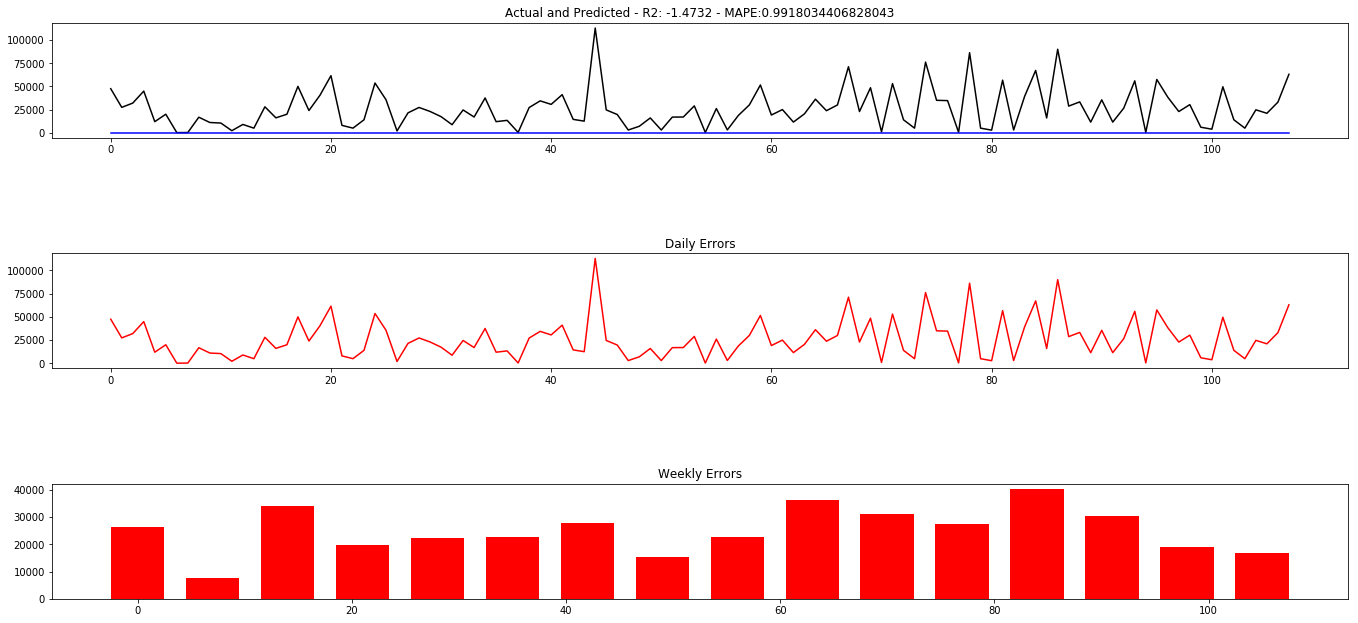

In [35]:
plot_prediction(Y_val_, model.predict(X_val_))

# Test Non-Normalized Model

In [36]:
X_test_ = test_data_dict[w]['X']
Y_test_ = test_data_dict[w]['Y']

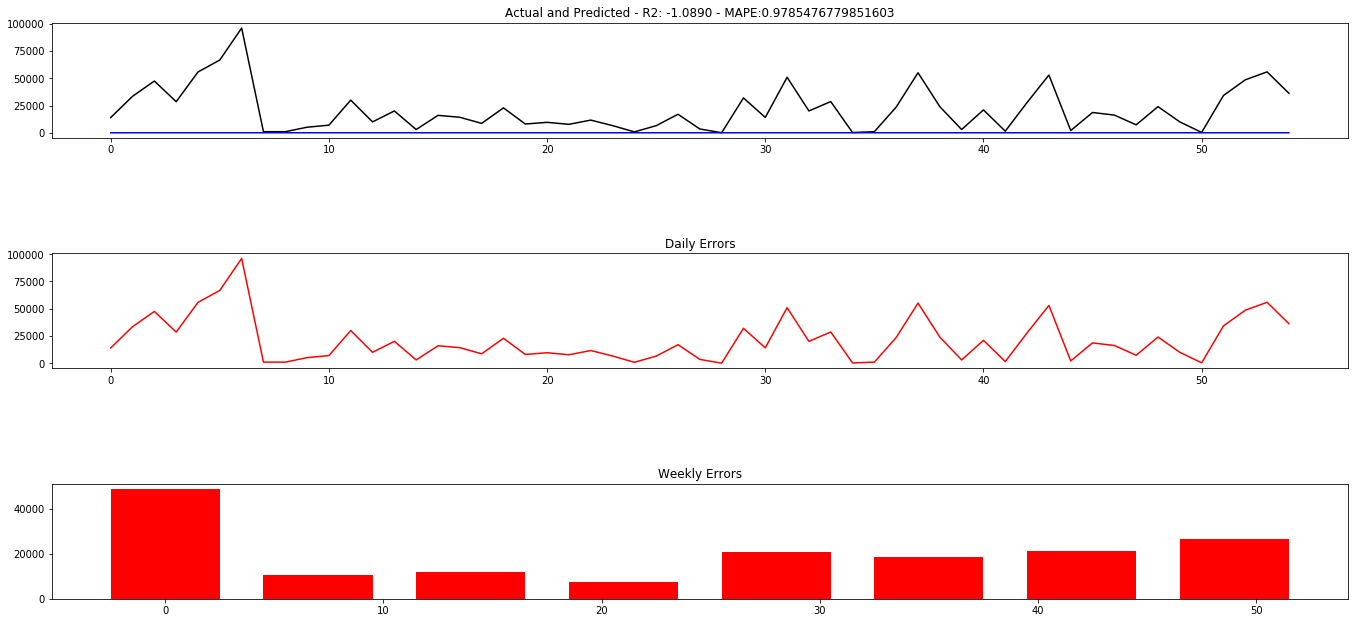

In [37]:
pred_y_ = model.predict(X_test_)
plot_prediction(Y_test_, pred_y_)

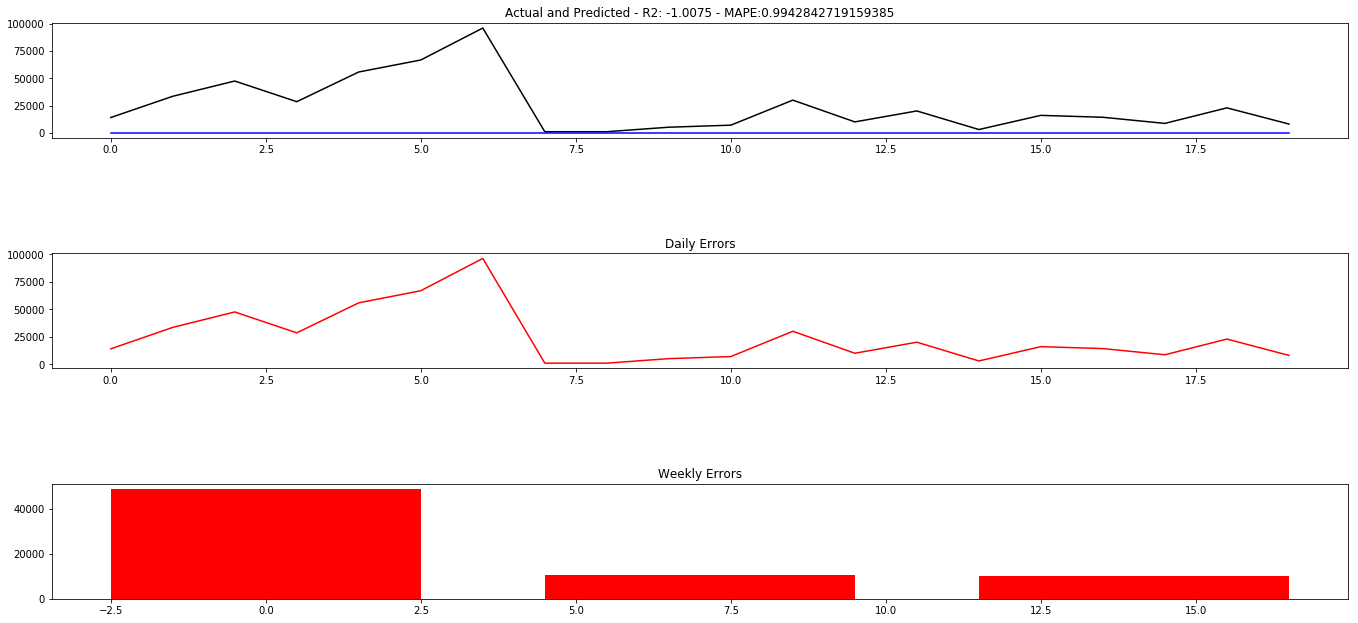

In [38]:
t=0
tp = 20
plot_prediction(Y_test_[t:t+tp], pred_y_[t:t+tp])